<a href="https://colab.research.google.com/github/khjinnn/AI_Section2_project/blob/main/AI_Section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필요한 라이브러리 설치
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap
!pip install eli5

### Scenario
A 회사의 인사부서는 직원들을 대상으로 1년에 한 번씩 정기적으로 설문조사를 실시하고 있다.  
해당 설문조사는 직원 개개인의 정보와 회사 생활에 대한 의견을 묻는 질문들로 구성되어 있다.  
인사부서는 현재까지 수집된 설문조사 데이터와 직원의 이직여부를 확인하여, 어떠한 상황과 조건에서 직원들이 이직을 하였는지 살펴보고자 한다.  
(이직한 사람들과 현재 재직중인 직원들에 대한 설문조사 데이터는 확보된 상태이다.)  
이번 프로젝트는 데이터사이언스팀과 협업하여 설문조사 데이터에서 인사이트를 발견하고, 이를 통해 직원의 이직을 예측하는 모델을 만드는 것을 목표로 한다.  

In [2]:
# 데이터 불러오기
import pandas as pd

df = pd.read_csv('attrition.csv')

In [3]:
df.head()

Age Attrition  ... YearsSinceLastPromotion  YearsWithCurrManager
0   41       Yes  ...                       0                     5
1   49        No  ...                       1                     7
2   37       Yes  ...                       0                     0
3   33        No  ...                       3                     0
4   27        No  ...                       2                     2

[5 rows x 35 columns]

### 설문조사 질문 내용  

[인적 사항] 
 

*   'Age' 나이  
'Gender' 성별  
'MaritalStatus' 결혼유무  
'Over18' 18세 이상 여부(근로가능 연령: 18세)  
'Education' 최종학력  
'EducationField' 전공  
'DistanceFromHome'통근거리  
'EmployeeNumber' 직원번호   

[직무 관련]  


*   'Department' 근무부서  
'StandardHours' 주 기본 근무시간  
'BusinessTravel' 출장빈도  
'JobInvolvement' 직무 몰입도  
'JobLevel' 직무 단계(높을 수록 직위가 높은 것)  
'JobRole' 직무 역할  
'EnvironmentSatisfaction' 근무환경 만족도  
'JobSatisfaction' 직무 만족도  
'RelationshipSatisfaction' 사내 관계 만족도  
'WorkLifeBalance' 워라밸  
'PerformanceRating' 직무 수행 평가 등급  
'TrainingTimesLastYear' 전년도 교육 시간  
'YearsSinceLastPromotion' 마지막 승진 후 기간(년)  
'YearsInCurrentRole' 현재 역할의 직임기간(년)  
'YearsWithCurrManager' 현재 책임자와의 근무 기간(년)  
  
[경력 관련]
  

*   'NumCompaniesWorked' 재직했던 회사의 수  
'YearsAtCompany' 현재 회사의 근속년수  
'TotalWorkingYears' 총 근무경력(이전회사 포함)  

[보상 관련]  


*   'HourlyRate' 시간당 임금요율  
'DailyRate' 일별 임금요율  
'MonthlyRate 월별 임금요율  
'MonthlyIncome' 월 수입  
'PercentSalaryHike' 임금 상승율  
'StockOptionLevel' 스톡옵션 레벨(숫자 클수록 높은 것)  




### 1) 타겟으로 사용할 특성 선택  
설문조사 데이터를 바탕으로 직원의 이직을 예측하는 모델을 만드는 것이 목표이므로 이직여부('Attrition')를 타겟 특성으로 설정한다.  
직원이 이직을 할 것인지, 하지 않을 것인지의 두 가지 범주로 나누는 분류모델을 만들어 문제를 해결할 것이다.

In [4]:
# 타겟 설정
target = 'Attrition'

### 2) 타겟의 분포 확인  
타겟의 갯수 확인 결과 이직한 직원이 16%, 재직중인 직원이 84% 이다.  
불균형한 타겟이므로 가중치를 두어 모델을 만들어야 한다.  

In [5]:
# 타겟의 범주 및 갯수 확인
df[target].value_counts()

No     1233
Yes     237
Name: Attrition, dtype: int64

In [6]:
# 타겟의 비율 확인
df[target].value_counts(normalize=True)

No     0.838776
Yes    0.161224
Name: Attrition, dtype: float64

In [7]:
# 그래프 선명도
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


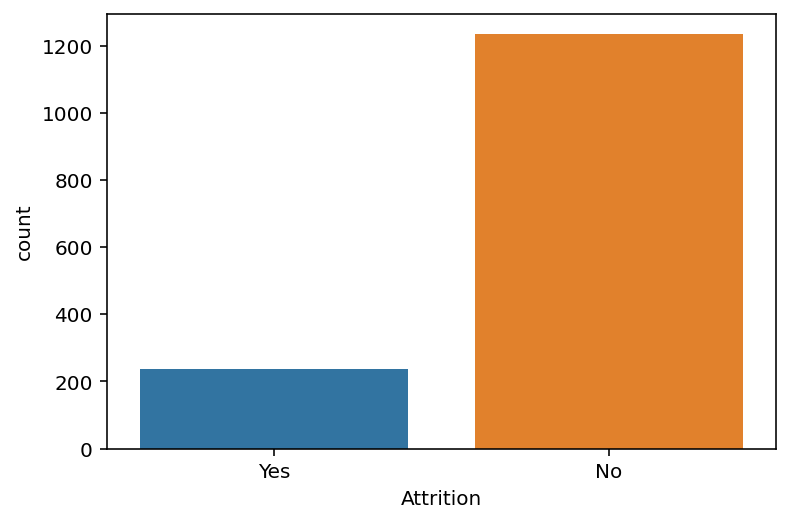

In [8]:
# 타겟의 갯수 시각화
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(df[target]);

### 3) 평가지표의 선택
해당 문제의 목표는 이직할 사람을 예측하여 이를 방지하고자 함이다.  
회사 차원에서 직원의 이직은 손실과 비용이 따르는 위험요인이기 때문이다.

타겟의 분포 확인 결과, Yes인 경우가 No인 경우에 비해 상당히 작은 불균형한 분포를 보인다.  
타겟이 불균형한 경우 모델이 정답을 맞추기 위해 단순히 다수의 타겟으로 모든 예측을 하는 경우 accuracy가 높게 나오게 된다.  
따라서 해당 문제의 평가지표로 accuracy는 부적절하므로 다른 평가지표를 사용해야한다.  

accuracy를 제외한 분류모델의 평가지표로 precision, recall, f1score를 고려해볼 수 있다.  
이직을 할 직원을 예측하여 이직을 방지하는 것이 목적이므로 Yes(이직)인 경우를 1로 예측하는 분류 모델이 되도록 한다.  
트레이닝셋으로 모델을 학습시켰을 때, 해당 모델에서 발생할 수 있는 오류는 두 가지가 있다.  

1.   모델은 이직을 예측했지만(1), 실제로는 이직을 하지 않은 경우(0)
2.   모델은 이직을 하지 않을 것으로 예측했지만(0), 실제로는 이직을 한 경우(1)

두 가지의 오류 중 향후 인사팀에게 치명적일 수 있는 것은 두 번째의 경우이다.  
모델이 이직을 하지 않을 것이라 예측하여 해당 직원의 이직을 방지할 수 있는 조치를 취하지 못하는 상황이 발생할수 있기 때문이다.  
이는 False Negative인 경우로, 해당 문제에서는 이 오류를 줄이는데 중점을 두어야 한다.  
따라서 모델의 평가지표로 AUC score를 채택하여 최적의 임계값에서의 모델의 성능(모델이 이직을 예측했을 때 얼마나 잘 맞추는지)을 확인하고자 한다.

### 4) EDA 및 Feature Engineering

In [9]:
# 타겟을 1(이직)과 0(재직)으로 바꾸어줌
df.Attrition.replace({'Yes': 1, 'No': 0}, inplace=True)

In [10]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(df)
#profile


In [11]:
# 프로파일에서 확인하여 하나의 값을 가지는 열 및 고유값만 가지는 열 삭제
#df.drop(columns=['EmployeeCount','Over18','StandardHours','EmployeeNumber'], axis=1, inplace=True)

In [12]:
#from pandas_profiling import ProfileReport

#profile = ProfileReport(df)
#profile


Profile Warnings  



*   Zero 관련 warnings 는 기간(년수)과 관련한 변수에서 발생한 것으로 1년이 지나지 않았다면 발생 가능한 수치이다.  
TrainingTimesLastYear has 197 (3.7%)  
YearsAtCompany has 44 (3.0%)  
YearsInCurrentRole has 244 (16.6%)  
YearsSinceLastPromotion has 581 (39.5%)  
YearsWithCurrManager has 263 (17.9%)  

*   상관관계가 높은 특성들은 추후 관계를 확인할 예정이다.  
JobLevel is highly correlated with MonthlyIncome  
MonthlyIncome is highly correlated with JobLevel    
Department is highly correlated with JobRole  
JobRole is highly correlated with Department  

In [13]:
# profile에서 상관관계가 높았던 특성들의 관계 확인
# JobLevel과 MonthlyIncome의 관계

import plotly.express as px
fig = px.scatter(df, x="JobLevel", y="MonthlyIncome", 
                 size='MonthlyIncome')
fig.show()

# 직위는 1에서부터 5까지 나뉘어져있으며, 직위가 높을 수록 임금의 분포가 높게 형성되어 있음을 확인할 수 있다.

In [14]:
fig = px.scatter(df, x=range(1,(len(df)+1)), y="MonthlyIncome", color="JobLevel"
                 )
fig.show()
# 단계별로 뚜렷한 임금의 변화를 확인할 수 있다.
# 해당 회사의 월 임금은, 직위에 따라서 결정됨을 유추해볼 수 있다.

In [15]:
df['JobRole'].unique()

array(['Sales Executive', 'Research Scientist', 'Laboratory Technician',
       'Manufacturing Director', 'Healthcare Representative', 'Manager',
       'Sales Representative', 'Research Director', 'Human Resources'],
      dtype=object)

In [16]:
fig = px.scatter(df, x="Department", y="JobRole")
fig.show()

# 세 부서는 모두 Manager가 존재하며, 다른 부서에 비해 R&D 부서의 역할이 세세하게 나누어져 있다.
# Sales 부서 직원들의 세부 역할은 Sales Executive, Manager, SalesRepresentative로 구성
# R&D 부서 직원들의 세부 역할은 Research Scientist, Laboratory Technician, Manufacturing Director,Healthcare Representative, Manager, Research Director으로 구성
# Human Resources 부서 직원들의 세부 역할은 Manager, Human Resources 로 구성

In [17]:
fig = px.scatter(df, x="JobRole", y="JobLevel")
fig.show()

# 직무역할 별로 직위가 어떻게 나뉘어 졌는지 확인해보았다.
# 높은 직위로 구성되어 있는 직무역할이 부서내에서 중요한 역할임을 유추해볼 수 있다.

In [18]:
# 수치형 변수와 타겟과의 상관관계 순서대로 나열
# 수치형 변수 하나와 타겟과의 상관관계가 0.5 이상인 변수는 없는 것으로 보ㅇ
#corr = df.corr()
#3corr['Attrition'].drop(['Attrition']).sort_values(ascending=False)

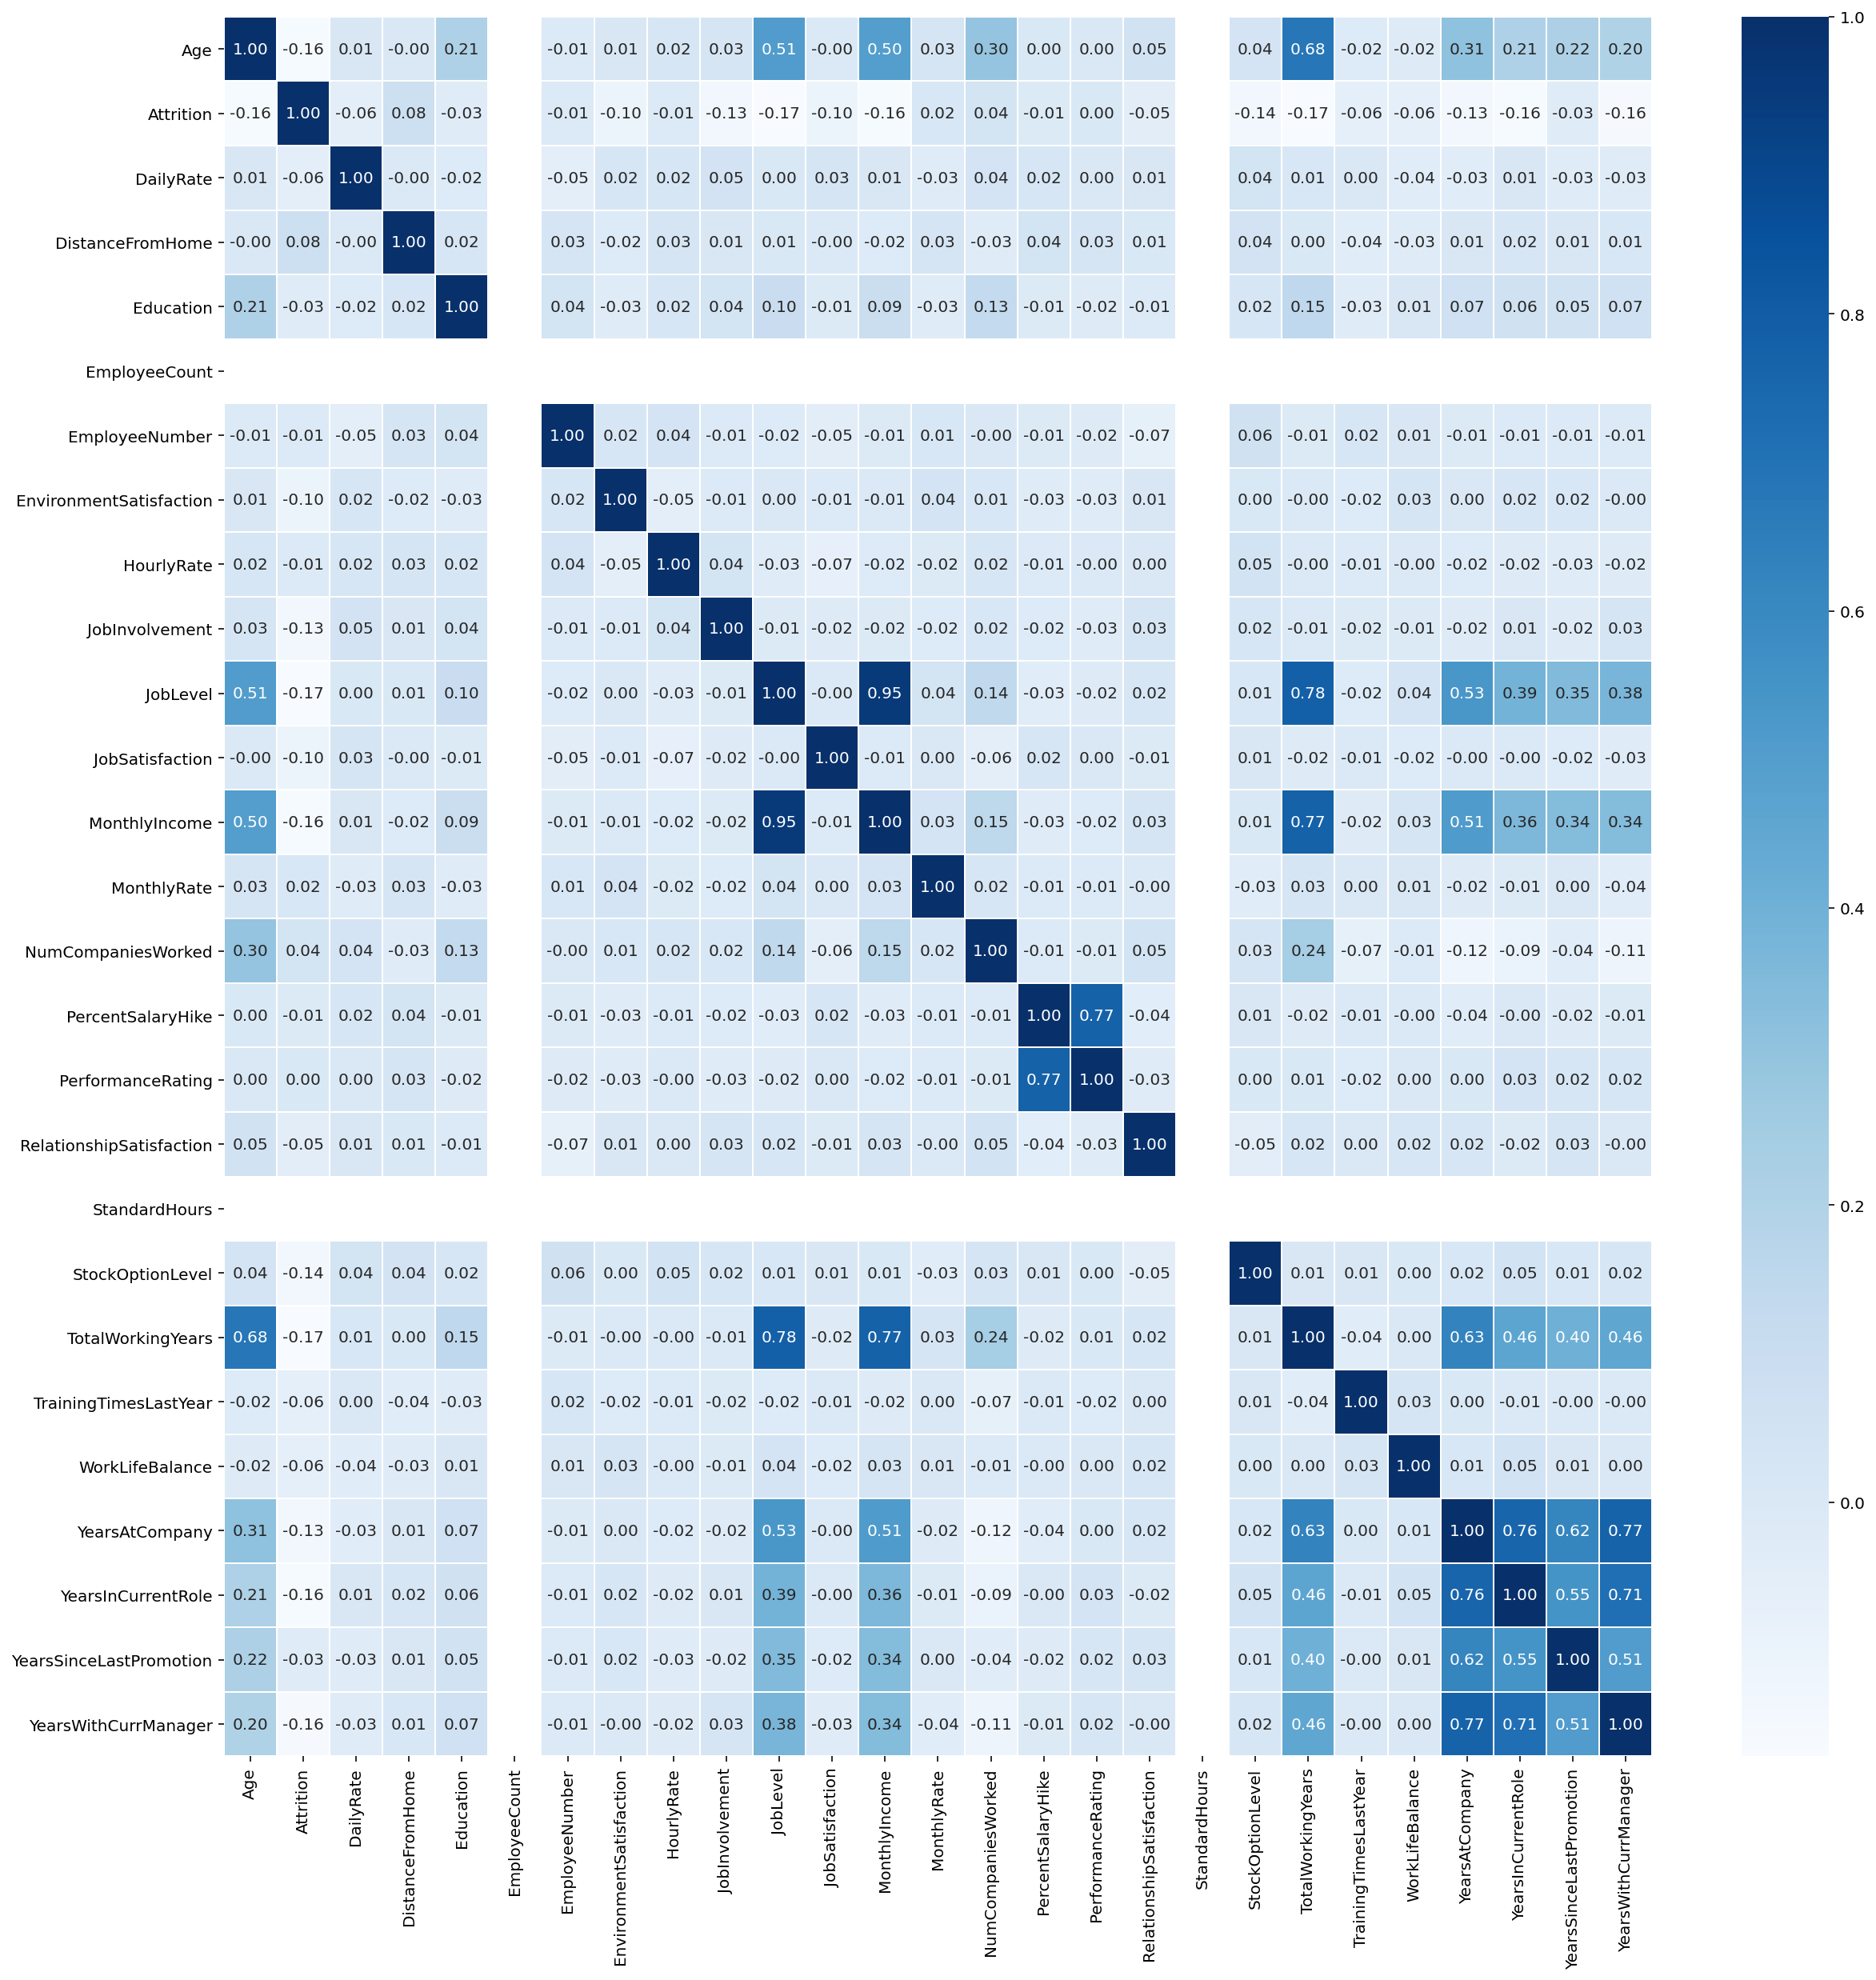

In [19]:
# 상관관계 시각화
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(data = corr, annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

In [20]:
# 상관관계 시각화에서 높은 상관관계를 보이는(0.5이상) 특성들에 대한 관계 확인

# 나이
# 직무단계
# 월임금
# 임금상승률
# 직무 수행 평가 등급
# 총 근무경력(년)
# 현재 회사의 근속년수
# 현재 역할의 직임기간(년)
# 승진 후 기간(년)
# 현재 책임자와의 근무기간(년)

In [21]:
# 연봉상승률은 근무성적평가등급과 높은 상관관계가 있다. 
# 근무성적평가등급은 3과 4로 나뉘어지는데, 3을 받은 경우의 연봉상승률은 20%미만이나, 4를 받은 경우의 연봉상승률은 20% 이상임을 확인할 수 있다.
# 근무에서 4(좋은 평가)를 받은 사람들을 대상으로 연봉을 더 올려주는 것으로 예상해볼 수 있다.

fig = px.scatter(df, x="PerformanceRating", y="PercentSalaryHike", 
                 size='PercentSalaryHike')
fig.show()


In [22]:
# ratio plot 시각화 위한 함수

def ratio_plot_by_group(data , value , group = None,  fig_kws={"stacked" : True, "title" : ""}) :
    if group is None :
        result = data[value].value_counts(normalize=True)
        multi_index = pd.MultiIndex.from_product([[value], result.index.unique().tolist()], 
                                         names=["group", value])
        result.index = multi_index
        result = result.unstack()
    else :
        result = data.groupby(group)[value].value_counts(normalize=True).unstack()
    result.plot(kind="bar", 
                stacked= fig_kws.get("stacked" , True), 
                title=fig_kws.get("title",""))
    plt.show()
    return None

In [23]:
# 데이터에 대한 가설
# 초과근무를 하는 직원들의 이직율이 높을 것이다.

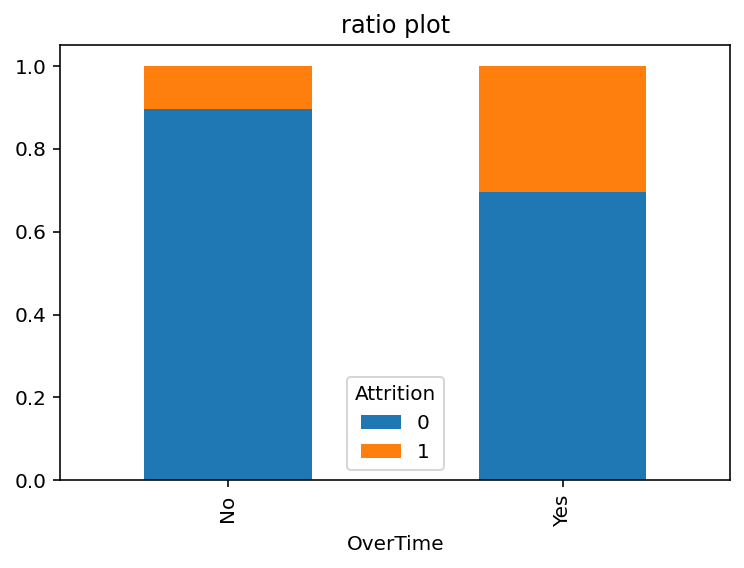

In [24]:
# 초과근무를 하는 사람일 수록 이직율이 높았다.
# 업무 강도가 높아 이직을 많이 결심한 것으로 예상된다.
ratio_plot_by_group(df ,"Attrition", group="OverTime",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [25]:
# 데이터에 대한 가설
# 나이가 많은 직원들 보다는 나이가 어린 직원들의 이직율이 높을 것으로 예상된다.

# 나이가 많은 직원들은 안정성을 선호할 것이고, 나이가 어린 직원은 보다 도전적으로 자신에게 맞는 회사를 찾아갈 것이다.
# 나이와 이직율 확인

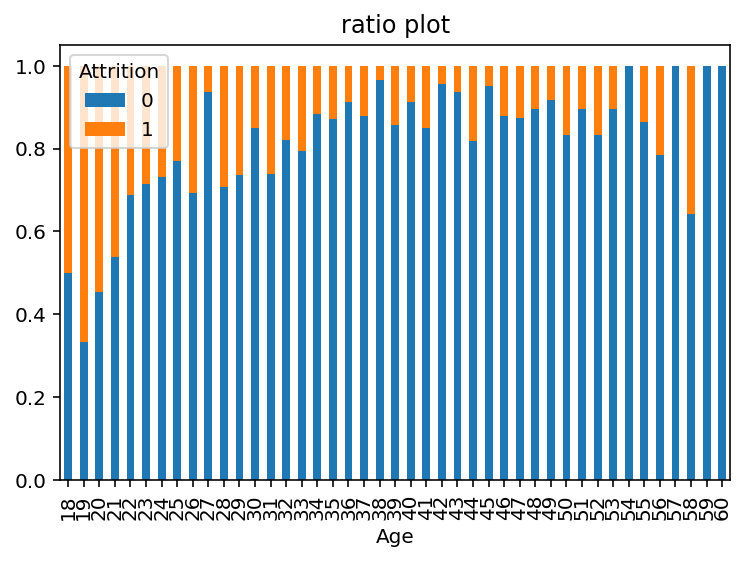

In [26]:
# 18~30세까지의 연령대에서 이직율이 두드러지게 높고, 그 외에는 연령마다 이직율이 다양하게 나타난다.
# 가설과는 달리 50대 후반의 연령대에서 이직율이 높아짐을 확인할 수 있다. 이는 타회사로의 이직이 아닌 조기 은퇴로 인한 직원 이탈로 보인다.   
ratio_plot_by_group(df ,"Attrition", group="Age",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [27]:
# 데이터에 대한 가설
# 결혼유무도 이직율에 영향이 있을 것이라 예상된다.

# 결혼을 한 직원들의 경우, 부양할 가족들이 있으므로 비혼인 직원들보다는 신중하게 이직을 결심할 것이다.
# 결혼유무와 이직율 확인

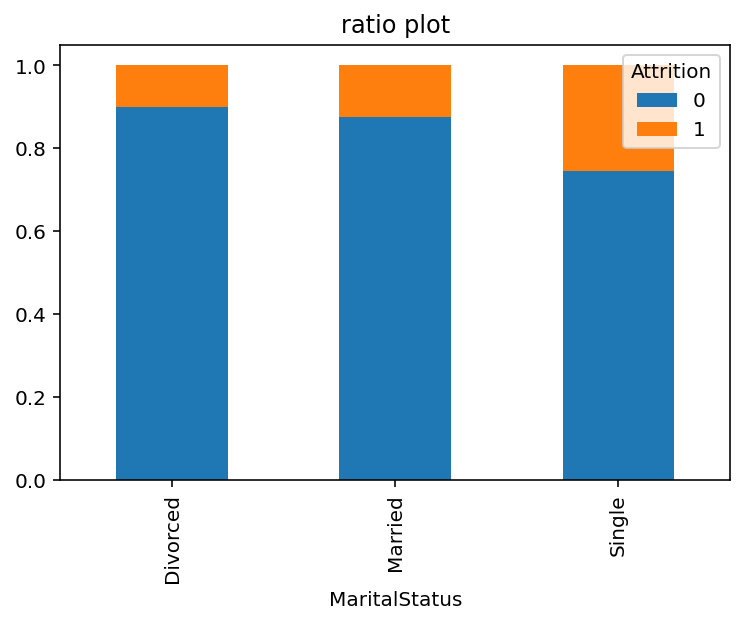

In [28]:
# 예상대로 비혼인 경우에 이직율이 높음을 확인할 수 있다.
ratio_plot_by_group(df ,"Attrition", group="MaritalStatus",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [29]:
# 데이터에 대한 가설
# 최종학력이 높을 수록 이직율이 높을 것이라 예상된다.

# 최종학력이 높은 직원의 업무성과가 좋다면, 다른 회사에서 좋은 조건으로 잡오퍼를 받아 이직을 하는 경우가 있을 것이다.
# 최종학력과 업무성과 확인, 최종학력과 이직율 확인 

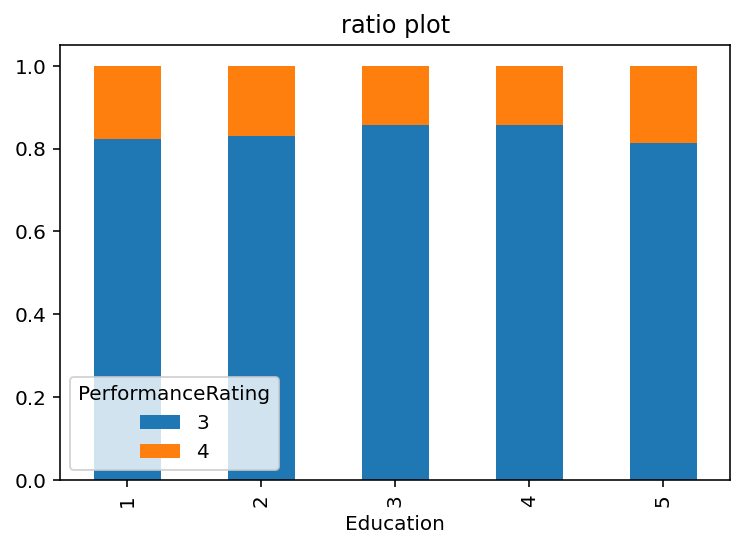

In [30]:
# 최종학력이 가장 높은 경우, 업무성과가 4인 비율이 가장 컸지만 그 외에는 큰 차이가 보이지 않는다.
ratio_plot_by_group(df ,"PerformanceRating", group="Education",fig_kws = {"stacked":True,"title" : "ratio plot"});

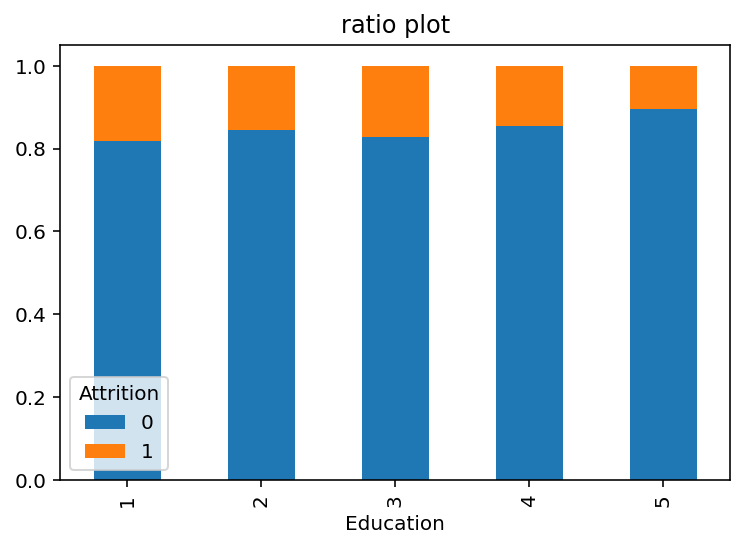

In [31]:
# 가설과는 달리 최종학력이 가장 높은 5에서 가장 낮은 이직율을 보이고 있다. 
# 최종학력이 높은 직원들이 좋은 성과를 내고, 그 성과에 대한 적절한 보상을 받고 재직중인 것으로 예상된다. 
ratio_plot_by_group(df ,"Attrition", group="Education",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [32]:
# 데이터에 대한 가설
# 통근거리가 길 수록 이직율이 높을 것이라 예상된다.

# 통근거리는 업무와 관련이 없지만 직원의 삶의 질에 큰 영향을 미치는 요인이다. 통근거리가 먼 직원들은 이직을 고려할 가능성이 크다.
# 통근거리와 이직율 확인

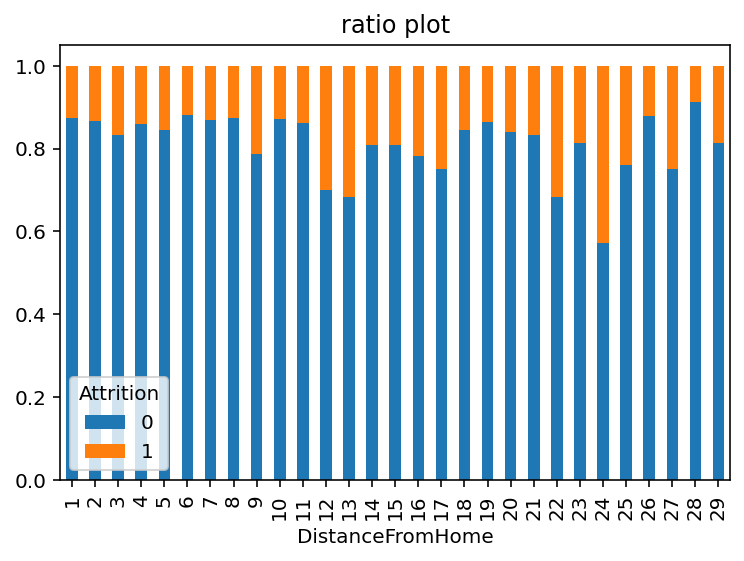

In [33]:
# 개인 편차가 있지만, 대체적으로 보았을때 통근거리가 멀어질 수록 이직율이 증가한다.
ratio_plot_by_group(df ,"Attrition", group="DistanceFromHome",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [34]:
# 데이터에 대한 가설
# 근무부서에 따라서 만족도, 보상이 다를 수 있기 때문에 이직율도 상이할 수 있다고 예상된다.

# 근무부서에 따른 만족도의 평균이 같은지 다른지 확인해본다.
# 근무부서에 따른 보상의 평균이 같은지 다른지 확인해본다.
# 근무부서에 따른 이직율 확인, 근무부서에 따른 만족도 확인

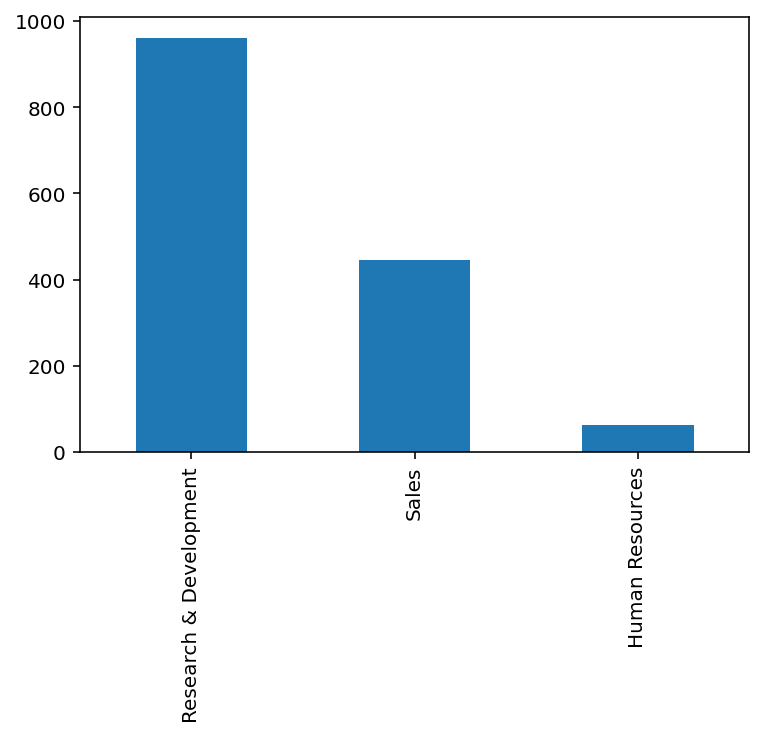

In [35]:
# 해당 회사에는 연구개발 부서에 소속되어 있는 직원이 가장 많다.
df['Department'].value_counts(dropna = False).plot.bar()
plt.show()

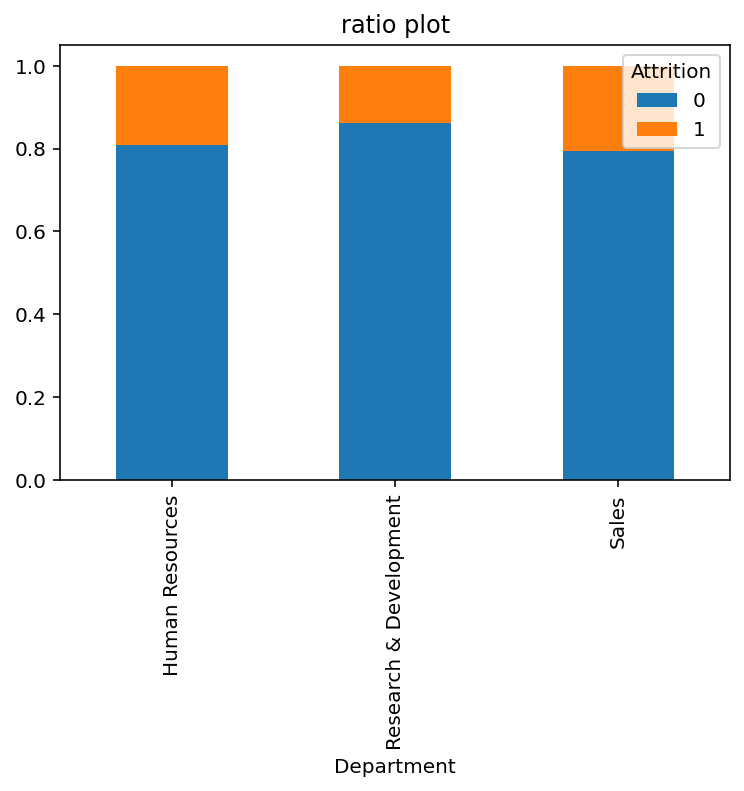

In [36]:
# 부서별 이직율은 상이하게 확인된다. R&D부서의 직원의 이직율이 타 부서보다는 적다.
ratio_plot_by_group(df ,"Attrition", group="Department",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [37]:
# 부서에 따른 만족도의 평균 확인 결과, 부서별로 차이가 미미한 수준이다.

In [38]:
df.groupby('Department').WorkLifeBalance.mean()

Department
Human Resources           2.920635
Research & Development    2.725286
Sales                     2.816143
Name: WorkLifeBalance, dtype: float64

In [39]:
df.groupby('Department').JobSatisfaction.mean()

Department
Human Resources           2.603175
Research & Development    2.726327
Sales                     2.751121
Name: JobSatisfaction, dtype: float64

In [40]:
df.groupby('Department').EnvironmentSatisfaction.mean()

Department
Human Resources           2.682540
Research & Development    2.744017
Sales                     2.679372
Name: EnvironmentSatisfaction, dtype: float64

In [41]:
df.groupby('Department').RelationshipSatisfaction.mean()

Department
Human Resources           2.888889
Research & Development    2.708637
Sales                     2.695067
Name: RelationshipSatisfaction, dtype: float64

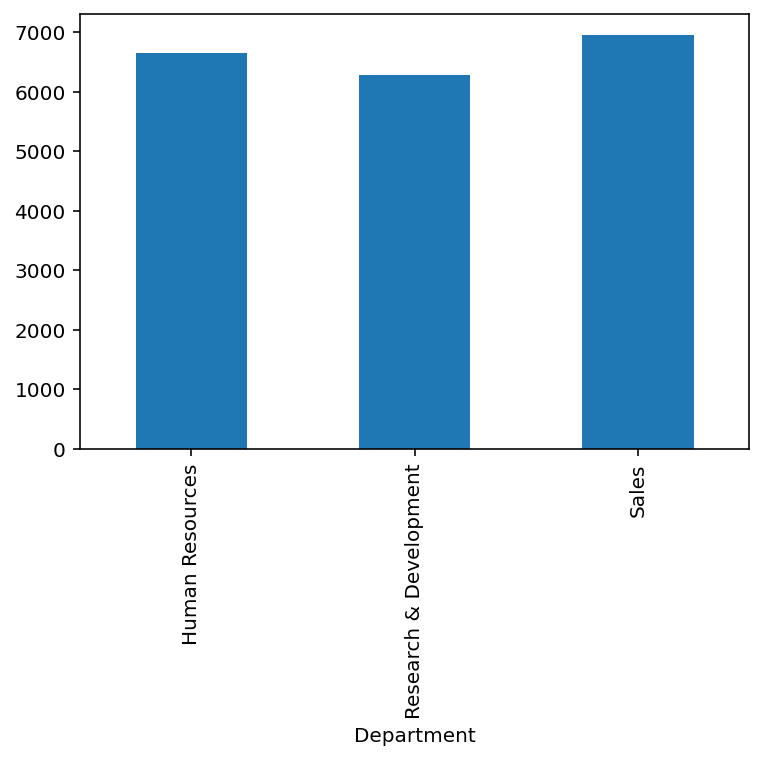

In [42]:
# 부서별 임금 확인 결과, R&D 부서의 이직율이 타 부서에 비해 낮음에도 불구하고 임금평균이 가장 낮았다.
df.groupby('Department').MonthlyIncome.mean().plot(kind='bar')

In [43]:
# 데이터에 대한 가설
# 출장빈도가 잦을 수록 이직율이 높을 것이다.

# 개개인에 성향에 따라 출장의 선호도가 다르겠지만, 일반적으로 출장이 잦은 경우 육체적으로 많은 에너지를 소모하므로 직무에 대한 만족도가 떨어질 것이다.
# 출장빈도에 따른 이직율 확인, 출장빈도에 따른 직무 만족도 확인, 출장빈도에 따른 근무환경 만족도 확인

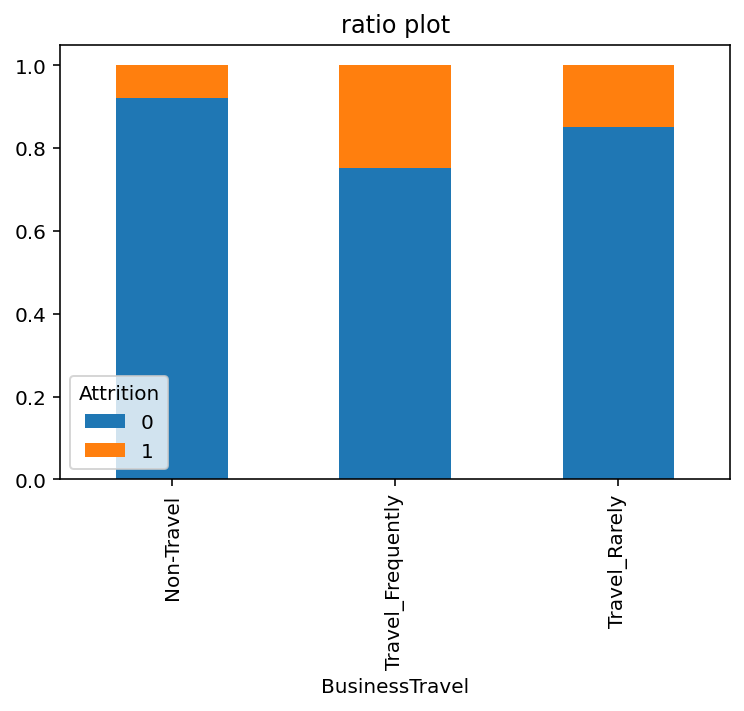

In [44]:
# 출장이 없거나 드물게 다니는 직원보다는 출장을 종종 가는 직원의 이직율이 높았다.
ratio_plot_by_group(df ,"Attrition", group="BusinessTravel",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [45]:
# 출장빈도에 따른 직무만족도 및 근무환경만족도 확인 결과 이직율 발생과는 다른 양상을 보였다.

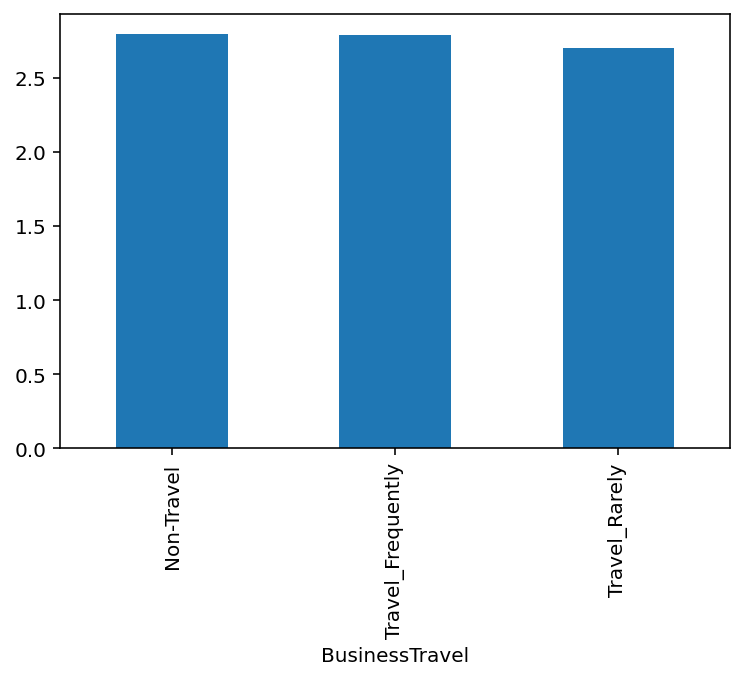

In [46]:
df.groupby('BusinessTravel').JobSatisfaction.mean().plot(kind='bar')

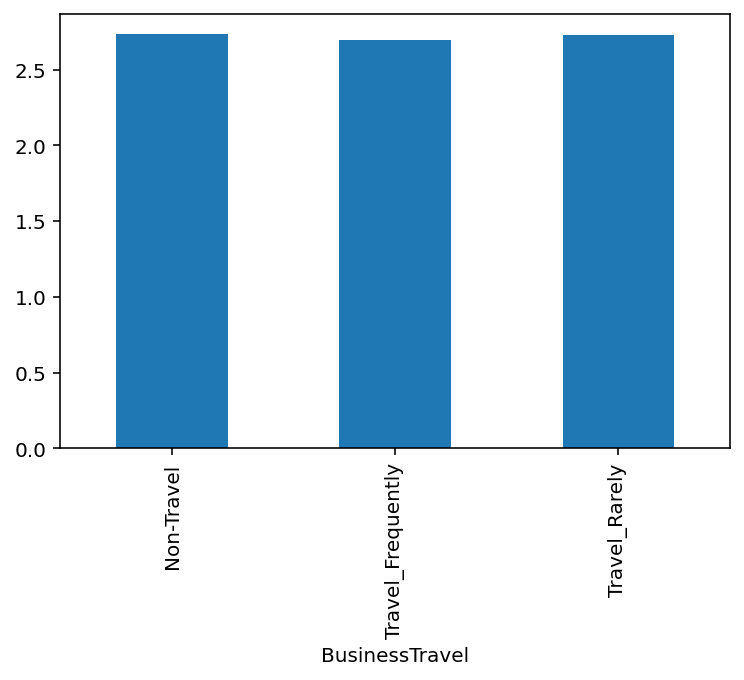

In [47]:
df.groupby('BusinessTravel').EnvironmentSatisfaction.mean().plot(kind='bar')

In [48]:
# 데이터에 대한 가설
# 직무 단계가 높을 수록 이직율은 낮을 것이다.

# 이미 회사에서 높은 직위에 있는 직원일 것이므로, 보상의 차원에서 회사의 대우가 좋을 것이며 이에 따라 이직율이 낮을 것으로 예상된다.
# 직무단계와 이직율 확인

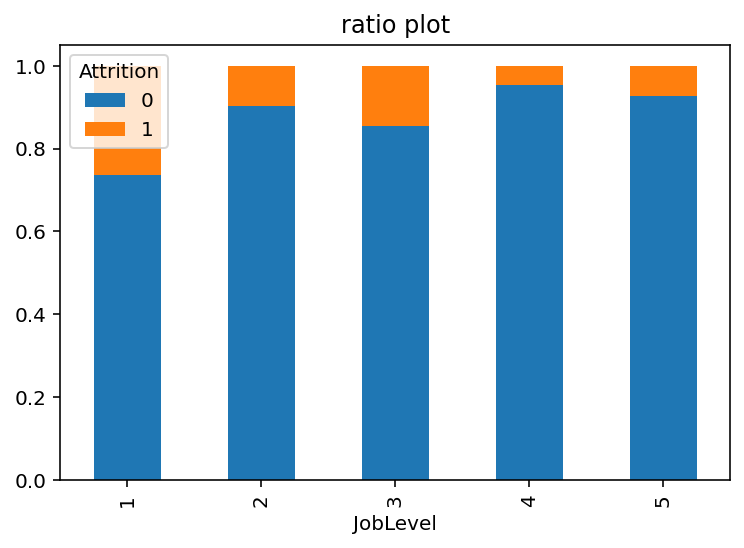

In [49]:
# 직무단계가 낮은 경우에는 이직율이 확연하게 높았으며, 4 이상인 경우에는 이직율이 낮음을 확인할 수 있다.
ratio_plot_by_group(df ,"Attrition", group="JobLevel",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [50]:
# 데이터에 대한 가설

# 만족도와 관련된 항목들은 이직율과 높은 상관관계가 있을 것으로 판단된다.
# 만족도 관련 항목 = 'EnvironmentSatisfaction' 근무환경 만족도 /'JobSatisfaction' 직무 만족도/'RelationshipSatisfaction' 사내 관계 만족도/'WorkLifeBalance' 워라밸  
# 각각의 만족도에 따른 이직율 확인

In [51]:
# 각각의 만족도에 따른 이직율 확인 결과, 만족도가 가장 낮을때의 이직율이 가장 높았으나 만족도가 2 이상인 경우에서는 확연한 차이를 확인하기는 힘들었다.
# 특히나 워라밸이 낮을때 이직율이 두드러지게 높아짐을 확인할 수 있다.

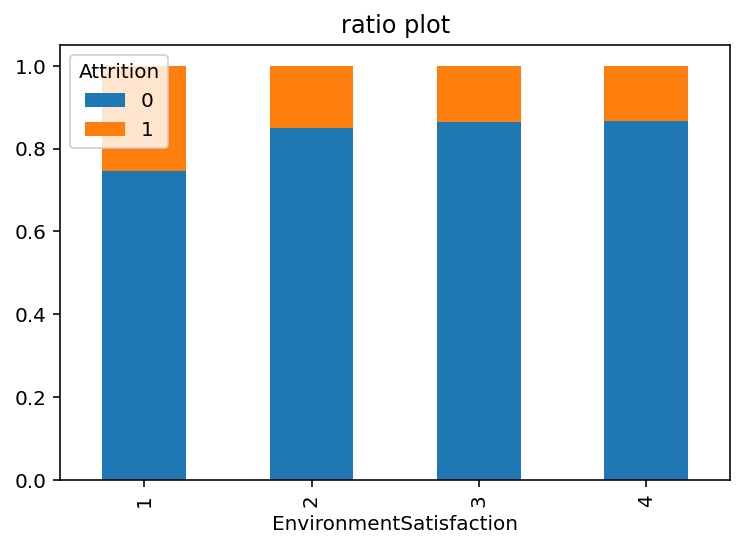

In [52]:
ratio_plot_by_group(df ,"Attrition", group="EnvironmentSatisfaction",fig_kws = {"stacked":True,"title" : "ratio plot"});

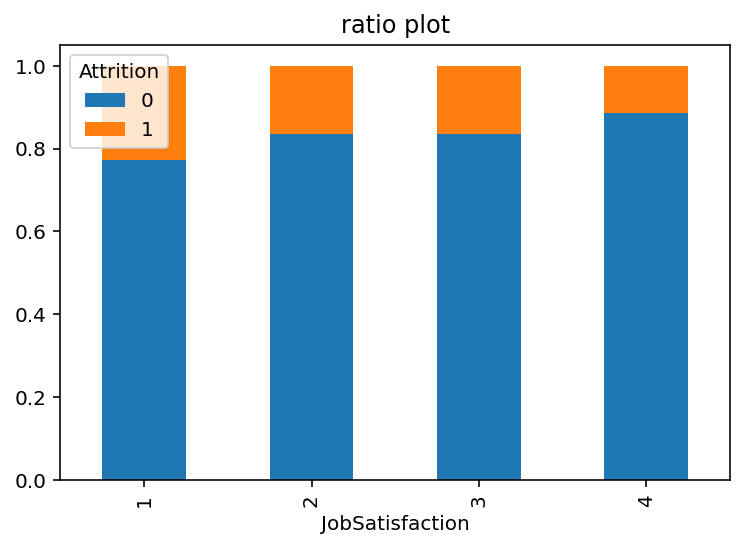

In [53]:
ratio_plot_by_group(df ,"Attrition", group="JobSatisfaction",fig_kws = {"stacked":True,"title" : "ratio plot"});

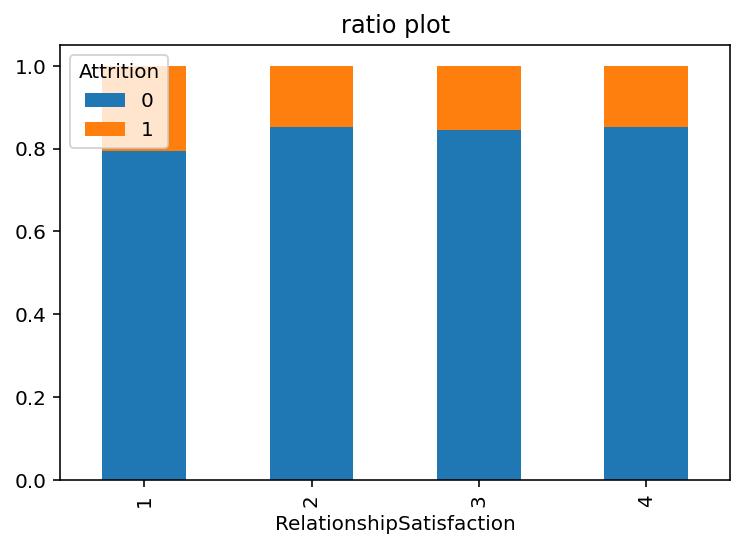

In [54]:
ratio_plot_by_group(df ,"Attrition", group="RelationshipSatisfaction",fig_kws = {"stacked":True,"title" : "ratio plot"});

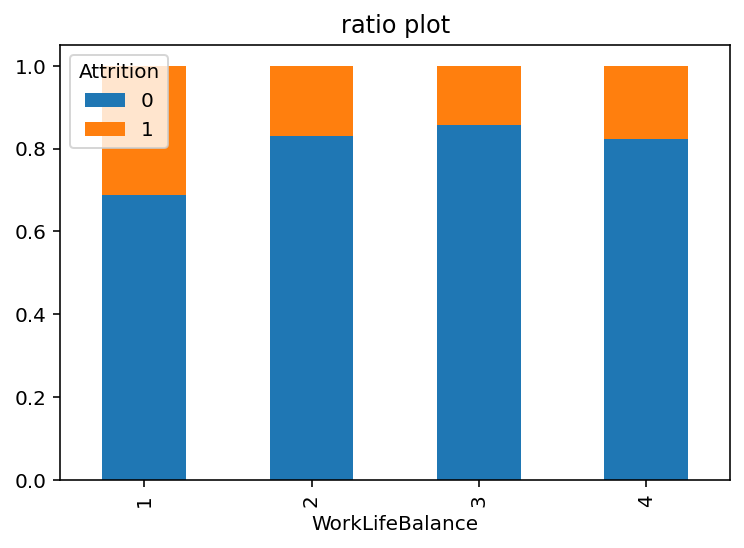

In [55]:
ratio_plot_by_group(df ,"Attrition", group="WorkLifeBalance",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [56]:
# 데이터에 대한 가설

# 마지막 승진 후 기간이 길수록 이직율이 높을 것이다.
# 승진제도는 회사에 대한 직원의 만족도와 직원의 임금과 연관이 있을 것이다. 승진하는데에 오랜 시간이 걸리는 직원들은 더 좋은 조건의 회사를 찾아서 이직을 생각해볼 가능성이 있다.
# 마지막 승진 후 기간에 따른 직무 만족도 확인, 마지막 승진 후 기간에 따른 이직율 확인

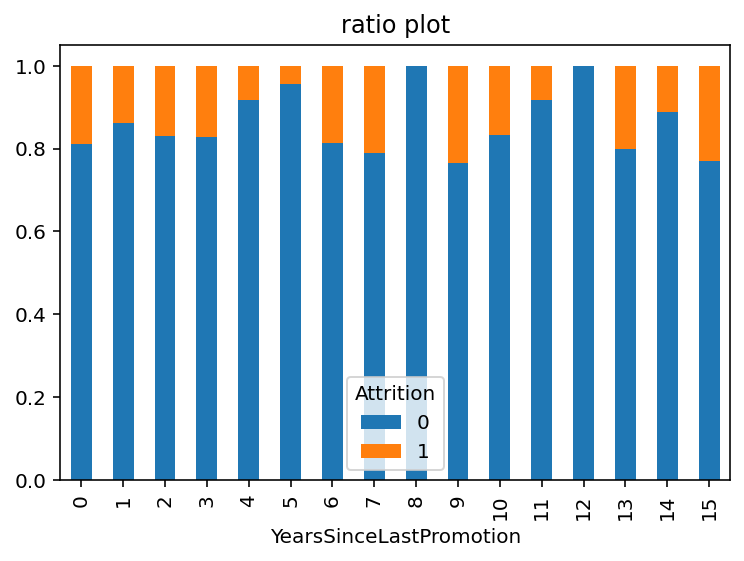

In [57]:
# 가설과는 다르게 기간에 비례하여 이직율이 증가하지 않는다. 이직율과는 큰 연관이 없는 것으로 보인다.
ratio_plot_by_group(df ,"Attrition", group="YearsSinceLastPromotion",fig_kws = {"stacked":True,"title" : "ratio plot"});

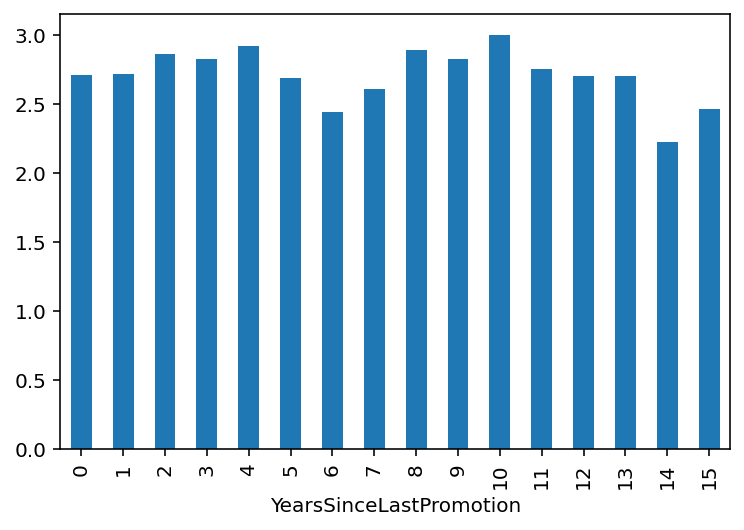

In [58]:
# 마지막 승진 후 기간에 따른 직무 만족도 확인결과 그 기간이 14,15년인 경우에 만족도는 눈에 띄게 낮아지지만, 이외의 경우에서는 별다른 연관성을 찾아보기 힘들다.
df.groupby('YearsSinceLastPromotion').JobSatisfaction.mean().plot(kind='bar')

In [59]:
# 데이터에 대한 가설
# 총 근무경력/ 재직했던 회사의 수 = 평균 재직년수 
# 평균 재직년수가 낮은 직원일 수록 이직을 할 가능성이 클 것이다.

# 평균 재직년수에 대한 새로운 피쳐 생성하여 해당 피쳐와 이직율의 관계 확인

In [60]:
# 한 직장에서 평균적으로 몇년 일하는 지에 대한 특성을 만듦
df['AverageWorkingYears'] = df['TotalWorkingYears'] / df['NumCompaniesWorked']

In [61]:
# inf는 현재 회사가 첫 직장인 사람에서 발생하는 값으로 0으로 대체함
import numpy as np
from numpy import inf

df['AverageWorkingYears'].replace(np.inf, 0, inplace=True)

In [62]:
# inf값 있는지 확인
np.isinf(df['AverageWorkingYears']).any()

False

In [63]:
# 정수타입으로 변경
df['AverageWorkingYears'] = df['AverageWorkingYears'].astype(int)

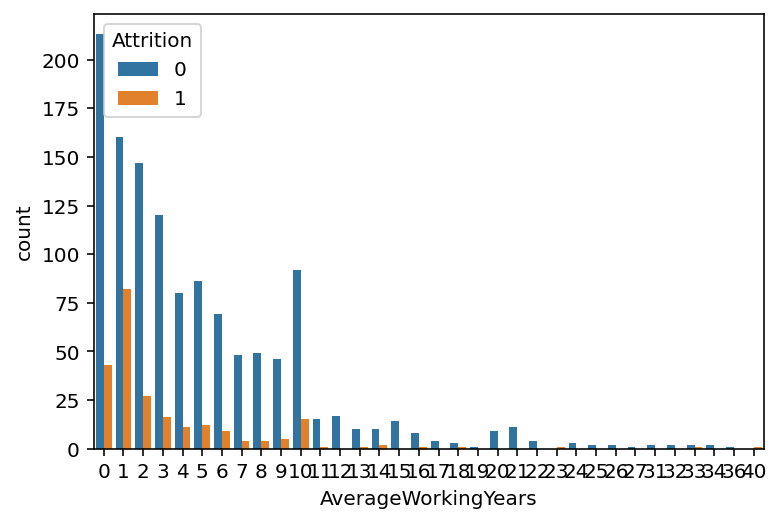

In [64]:
# 평균재직년수가 10년 이하일 때, 이직하는 직원들이 많다.  
sns.countplot(data = df, x= "AverageWorkingYears",  hue = "Attrition")

In [65]:
# 데이터에 대한 가설
# 현재 회사의 근속년수/ 총 근무경력 = 전체 경력 중 현재 회사에서의 경력 = 회사에 대한 충성도
# 회사에 대한 충성도가 높은 직원일 수록 이직을 할 가능성이 낮을 것이다.

# 회사에 대한 충성도로 새로운 피쳐 생성하여 이직율과의 관계 확인 

In [66]:
# 현재 회사에 대한 충성도 (현재까지 근무경력중 현재 회사에서의 근속년수 대한 비율)특성을 만듦
# 충성도가 높을 수록 이탈율이 낮을 것으로 예상해봄
df['YearsAtCompany_Of_Total'] = df['YearsAtCompany'] / df['TotalWorkingYears'] *100

In [67]:
# nan은 현재 회사가 첫 직장인 사람에서 발생하는 값으로 0으로 대체함

df['YearsAtCompany_Of_Total'].replace(np.nan, 0, inplace=True)

In [68]:
np.isnan(df['YearsAtCompany_Of_Total']).any()

False

In [69]:
# % 단위로 바꾸어줌
df['YearsAtCompany_Of_Total'] = df['YearsAtCompany_Of_Total'].astype(int) * 0.01

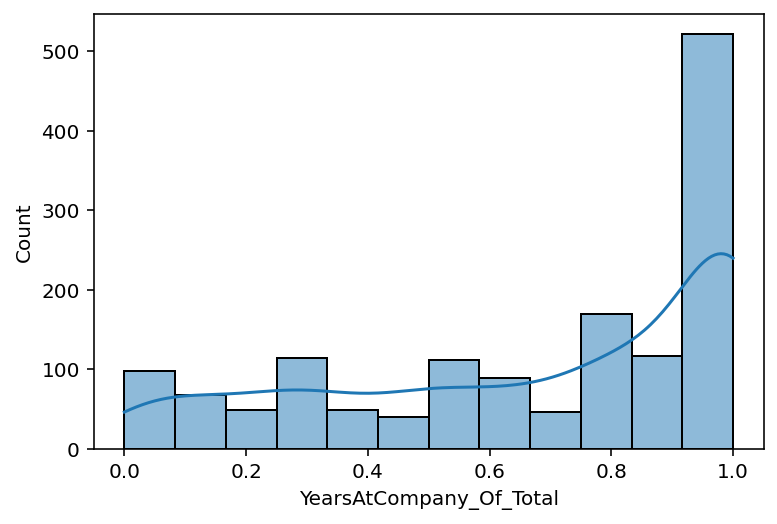

In [70]:
sns.histplot(df['YearsAtCompany_Of_Total'],kde=True);

In [71]:
df['YearsAtCompany_Of_Total'].value_counts()

1.00    463
0.50     59
0.83     55
0.00     44
0.80     42
       ... 
0.54      1
0.89      1
0.43      1
0.02      1
0.79      1
Name: YearsAtCompany_Of_Total, Length: 89, dtype: int64

In [72]:
a = df[df['YearsAtCompany_Of_Total']==1]

In [73]:
a['Attrition'].value_counts(normalize=True)

0    0.818575
1    0.181425
Name: Attrition, dtype: float64

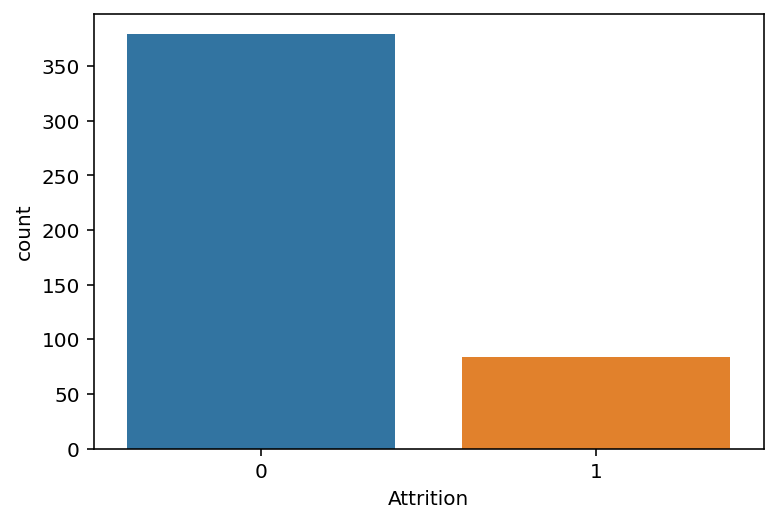

In [74]:
sns.countplot(data = a, x='Attrition')

In [75]:
b = df[df['YearsAtCompany_Of_Total']<=0.2]

In [76]:
b['Attrition'].value_counts(normalize=True)

0    0.808081
1    0.191919
Name: Attrition, dtype: float64

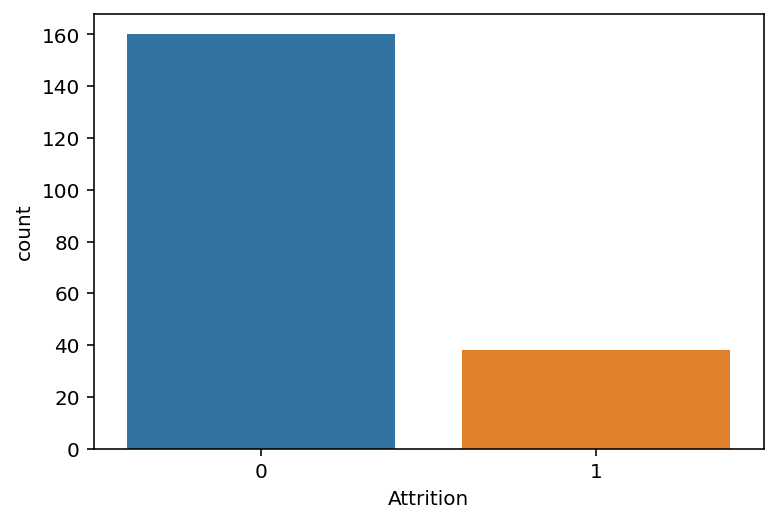

In [77]:
sns.countplot(data = b, x='Attrition')

In [78]:
# 새로 생성한 피쳐인 회사에 대한 충성도에 따른 이직여부 확인해보았으나, 충성도가 100%일때, 20%미만일때를 비교해 본 결과 이직율에 큰 차이가 없었다.

In [79]:
# 데이터에 대한 가설
# 임금상승률이 높았던 직원은 이직을 할 가능성이 낮을 것이다.

# 최근에 임금이 올랐으므로, 당분간은 재직을 하는 직원들이 많을 것이다.
# 임금상승률에 따른 이직율 확인 

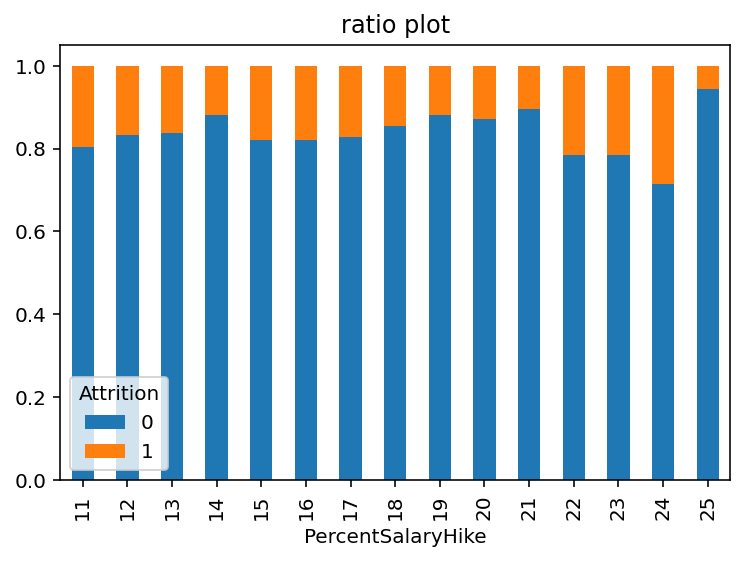

In [80]:
# 임금상승률이 가장 높았던 직원의 경우는 이직율이 가장 낮았지만, 임금상승률에 비례하여 이직율이 감소하지는 않았다.

ratio_plot_by_group(df ,"Attrition", group="PercentSalaryHike",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [81]:
# 데이터에 대한 가설
# 스톡옵션 레벨이 높을 수록 이직을 할 가능성이 낮을 것이다.

# 스톡옵션은 임금 외에 직원에게 부여되는 보상이기 때문에, 높은 스톡옵션 레벨을 가지고 있다면 이를 행사하기 전까지 이직을 할 가능성이 낮을 것이다.
# 스톡옵션 레벨에 따른 이직율 확인

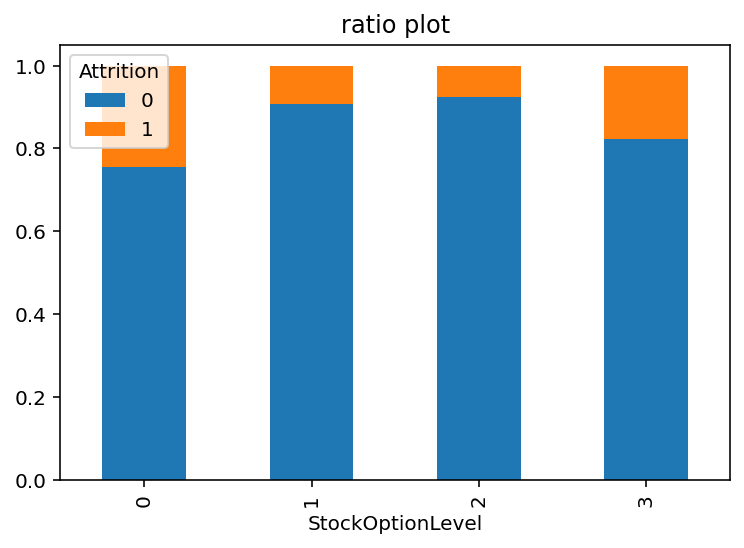

In [82]:
# 스톡옵션이 아예 없는 경우에는 있는 경우보다 이직율이 높은 것으로 확인된다.
# 스톡옵션을 가지고 있는 경우에는 가설과는 달리 level이 3인 경우의 이직율이 가장 높은 것으로 보아 스톡옵션의 레벨은 이직율과 비례하지 않는다.
ratio_plot_by_group(df ,"Attrition", group="StockOptionLevel",fig_kws = {"stacked":True,"title" : "ratio plot"});

In [83]:
# 하나의 값을 가지는 특성 및 고유값만 가지는 특성 삭제
df.drop(columns=['EmployeeCount','Over18','StandardHours','EmployeeNumber'], axis=1, inplace=True)

In [84]:
# 만족도에 관한 특성을 하나로 묶음
df['OverallSatisfaction'] = df['JobSatisfaction'] + df['RelationshipSatisfaction'] + df['EnvironmentSatisfaction']
df.drop(columns=['JobSatisfaction','RelationshipSatisfaction','EnvironmentSatisfaction'],axis=1,inplace=True)

In [85]:
# Hourly, Daily, Monthly Rate은 결국 Monthly income 에 반영될 것이므로 해당 특성 삭제
df.drop(columns=['HourlyRate', 'DailyRate', 'MonthlyRate'],axis=1,inplace=True)

In [86]:
# 수치데이터인 통근 거리를 카테고리형(가깝다/ 보통/ 멀다)으로 바꾸기 위한 함수
def group1(data):
    if int(data) >=1 & int(data) <= 5:
        return 'NearBy'
    elif int(data) >=6 & int(data) <= 15:
        return 'MidDistance'
    else:
        return 'Far'

# 년도에 대한 수치 데이터 또한 기준을 정하여 카테고리형(짧다 /보통/ 길다)으로 바꾸기 위한 함수
def group2(data):
    if int(data) >=0 & int(data) <= 3:
        return 'short'
    elif int(data) >3 & int(data) <= 8:
        return 'medium'
    else:
        return 'long'

# 근무 기간에 대한 데이터를 5년 이하면 짧음, 5년 이상10년이하면 보통, 그 이상이면 길다 로 바꾸기 위한 함수     
def group3(data):
    if int(data) >=0 & int(data) <= 5:
        return 'short'
    elif int(data) >5 & int(data) <= 10:
        return 'medium'
    else:
        return 'long'

In [87]:
# 해당하는 feature에 적용
df['DistanceFromHome'] = df['DistanceFromHome'].apply(group1)
df['YearsInCurrentRole'] = df['YearsInCurrentRole'].apply(group2)
df['YearsWithCurrManager'] = df['YearsWithCurrManager'].apply(group2)
df['YearsSinceLastPromotion'] = df['YearsSinceLastPromotion'].apply(group2)
df['YearsAtCompany'] = df['YearsAtCompany'].apply(group2)
df['TotalWorkingYears'] = df['TotalWorkingYears'].apply(group3)

In [88]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'Gender', 'JobInvolvement', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'AverageWorkingYears', 'YearsAtCompany_Of_Total',
       'OverallSatisfaction'],
      dtype='object')

### 5) Hold-out 검증방식으로 데이터셋 분할

In [89]:
from sklearn.model_selection import train_test_split

X = df.drop('Attrition', axis=1)
y = df['Attrition']
# X는 특성(피쳐)데이터, y는 타겟(라벨)데이터

# 전체 데이터를 훈련세트와 테스트세트로 나눔 (8:2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1)

# 훈련세트를 훈련데이터와 검증데이터로 나눔 (7.5:2.5) 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) 
# 0.25 x 0.8 = 0.2

# 전체 데이터에 대한 훈련/검증/테스트 세트 비율 (6:2:2)
# 최종적으로 각 데이터들의 shape 확인 필요

### 6) 기준모델 설정

In [90]:
# 분류문제의 기준모델설정
# 위에서 가장 높은 빈도의 클래스로 모든 예측을 하는 모델을 만든다

baseline = y_train.mode()[0] # 1을 반환함
# mode(): 최빈값을 가져옴(같을 경우엔 여러값 가져옴, [0] 붙일 경우, 그 값들 중 첫번째로 나오는 값 반환) 

y_pred = [baseline] * len(y_train)
# 타겟 샘플 수 만큼 최빈 클래스가 담긴 리스트 생성 (기준모델로 예측)

# 기준모델의 트레이닝셋에서의 예측 성능 확인
# 분류모델의 Evaluation Metrics = accuarcy score(정확도) = 정확한 예측수 / 전체 예측수
from sklearn.metrics import accuracy_score
print("[기준모델]training accuracy: ", accuracy_score(y_train, y_pred))

[기준모델]training accuracy:  0.8469387755102041


In [91]:
# 타겟 갯수 리스트로 만들기 
vc = y_train.value_counts().tolist() 
vc

[747, 135]

In [92]:
# 타겟 비율 ratio 변수에 저장
ratio = float(vc[0]/vc[1]) 
ratio

5.533333333333333

In [93]:
# DecisionTree로 모델 만들기
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(), 
		DecisionTreeClassifier(random_state=2)
)
# random_state 으로 랜덤성 고정

pipe.fit(X_train, y_train)

print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

훈련 정확도:  1.0
검증 정확도:  0.782312925170068


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [94]:
# 기준모델보다도 성능이 좋지 못하다. 훈련데이터에 과적합하여 일반화가 잘 되지 않았다고 볼 수 있다.

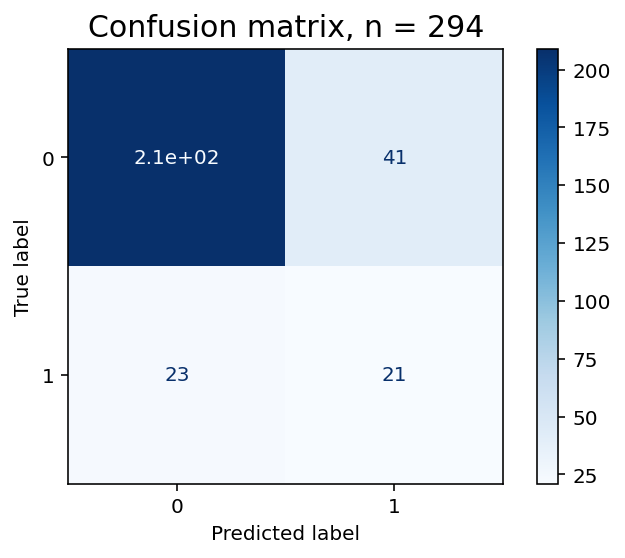

In [95]:
# confusion matrix를 확인해 보아도, 모델은 대부분 0으로 예측했음을 알 수 있다.
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [96]:
from sklearn.metrics import classification_report

y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       250
           1       0.34      0.48      0.40        44

    accuracy                           0.78       294
   macro avg       0.62      0.66      0.63       294
weighted avg       0.82      0.78      0.80       294



In [97]:
# 불균형한 타겟에 가중치를 주어 비율을 맞추고, 과적합을 방지하게 위해서 max_depth를 설정하여 주었다.

pipe = make_pipeline(
    OrdinalEncoder(), 
		DecisionTreeClassifier(random_state=2, class_weight='balanced', max_depth=5)
)
# class_weight 설정
# max_depth 설정

pipe.fit(X_train, y_train)

print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.6904761904761905


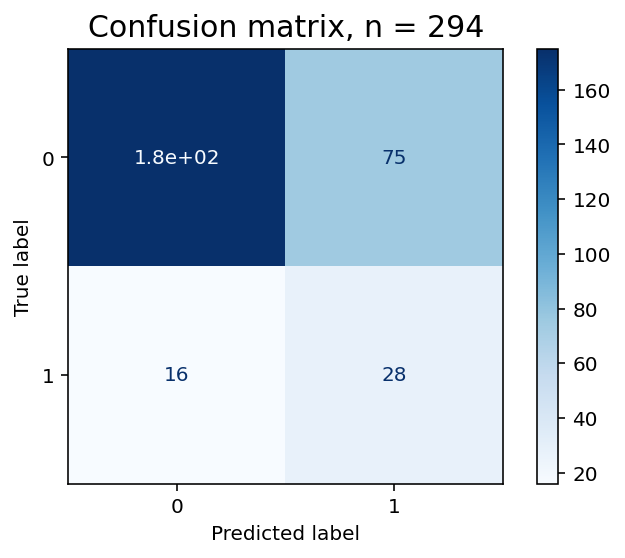

In [98]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [99]:
# 클래스에 가중치를 부여, max_depth 설정한 뒤 recall 값이 상승하였으나
# 여전히 accuracy는 기준모델보다 좋지 않다.
y_pred = pipe.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79       250
           1       0.27      0.64      0.38        44

    accuracy                           0.69       294
   macro avg       0.59      0.67      0.59       294
weighted avg       0.82      0.69      0.73       294



In [100]:
# AUC score를 확인한다.
from sklearn.metrics import roc_auc_score

y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.7298636363636365


Text(0, 0.5, 'TPR')

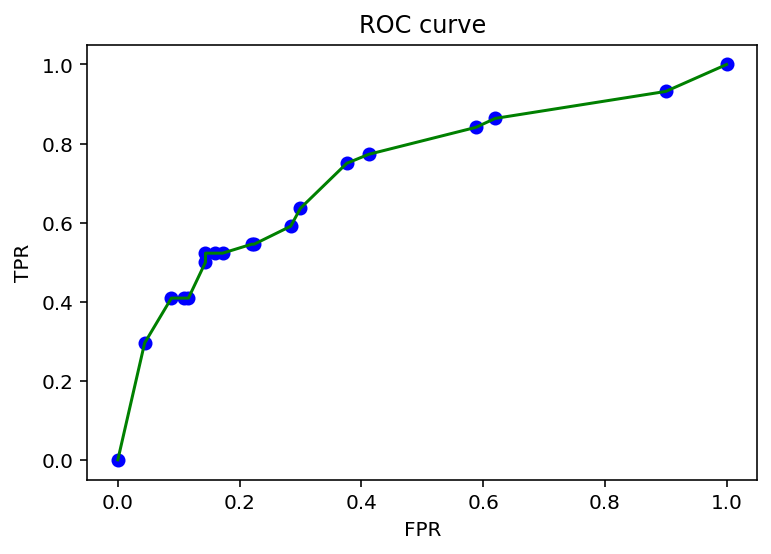

In [101]:
# 그래프의 현이 좌상단에 가까울 수록 성능이 좋다고 판단할 수 있는데, 현재 그래프는 거의 y=x에 가깝다.
# 성능의 개선이 필요하다.
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

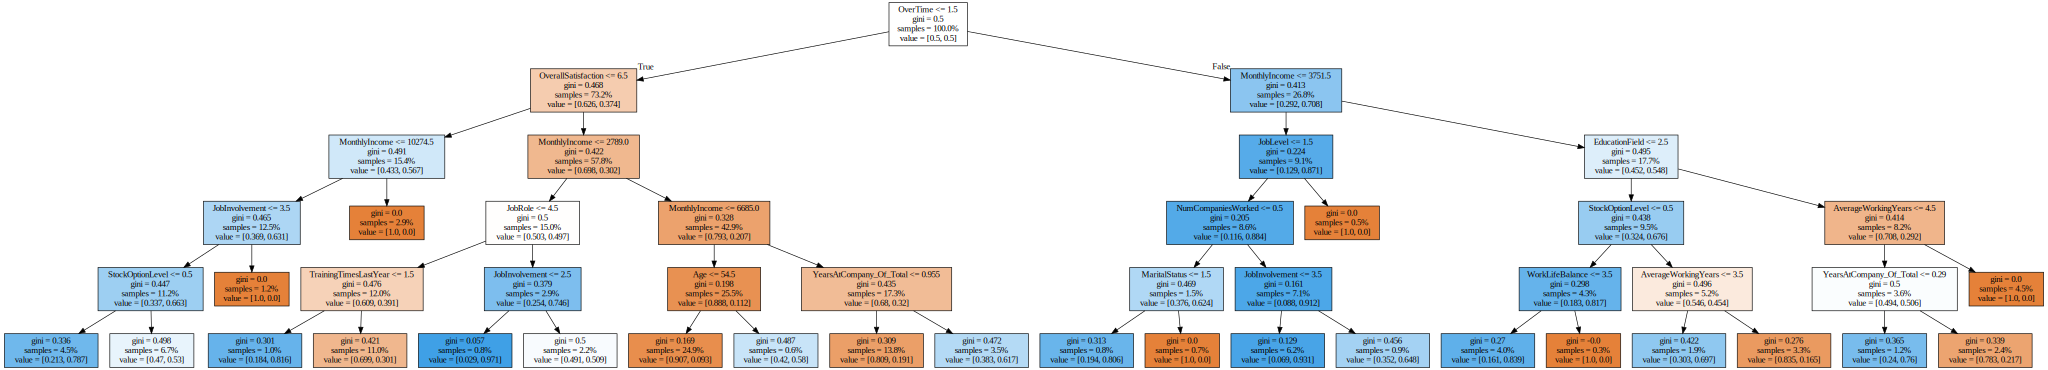

In [102]:
# 정보누수가 있는지 확인하기 위하여 모델이 어떻게 만들어졌는지 확인해보았다.
import graphviz
from sklearn.tree import export_graphviz

model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['ordinalencoder']
encoded_columns = enc.transform(X_val).columns

dot_data = export_graphviz(model_dt
                          , feature_names=encoded_columns
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))

### 7) 정보누수 확인

In [103]:
# 정보누수?

# 정보 누수의 확인을 위하여 decisiontree모델의 분기 확인 결과 누수는 없는 것으로 판단된다.
# 정보의 누수를 방지하기 위해서 각각의 특성이 타겟 데이터를 얻는 시점에 사용할 수 있는 데이터인지 확인하였다.
# 데이터의 특성들은 타겟 데이터를 얻기 전에 만들어질 수 있는 특성들로, 타겟에 영향을 받은 데이터는 없었다.
# 또한 해당 데이터는 시계열 데이터가 아니기 때문에 hold-out 방법으로 훈련데이터와 검증데이터를 완전히 분리하였다.

### 8) 모델의 유용성 및 한계점

In [104]:
# 해당 모델이 언제 유용한지?

# 해당 모델은 인사부서가 가지고 있는 직원에 대한 정보와 간단한 설문조사 데이터를 활용하여 이직을 예측할 수 있다.
# 설문조사 데이터를 수집하는 것 외에는 추가적인 경제적 자원과 시간이 들지 않으므로 경제적이다.

# 해당 예측 모델을 통하여 이직을 할 것으로 예상되는 직원들을 집중적으로 관리하여 이직을 방지할 수 있으며
# 예상되는 이직인원을 파악하여 채용 계획에도 반영하여 부서 업무의 기획에 도움을 줄 수 있다. 

In [105]:
# 어떤 한계가 있는지?

# 설문조사를 하는 특정 시점에서의 데이터이기 때문에, 설문조사 후 오랜기간이 흐른 경우에는 데이터에 변화가 있을 수 있으므로 예측력이 감소할 것이다.
# 특히나 주관적인 설문 문항은 끊임없이 바뀔 수 있다는 점을 염두에 두어야 한다.  

# 해당 모델은 직원 개개인이 직접 응답한 설문조사 데이터를 바탕으로 이직을 예측하는 모델이기에 한계점을 가진다.
# 첫 번째 한계는 직원이 주관적인 설문조사 항목에 대해 얼마나 솔직하게 임했느냐에 따라 예측결과가 달라질 수 있다는 점이다.
# 해당 설문조사는 익명성이 보장되지 않았기 때문에 회사에 대한 만족도에 대한 항목들에서 실제 만족도와 오차가 발생할 수 있다.

# 두 번째 한계는 직원들은 설문조사 항목에 있는 것 이외에도 다양한 이유로 이직을 할 수 있다는 점이다.
# 개인적인 사유로 이직하는 경우, 자기계발을 위하여 이직하는 경우, 혹은 타 회사에서 높은 경제적 보상으로 스카우트되어 이직하는 경우 등은 해당 모델로 정확한 예측이 불가능하다.

### 9) 여러가지 모델 실험

### 1. RandomForest 

검증데이터 accuracy = 0.86  
검증데이터 auc_score = 0.79  


랜덤포레스트 모델을 사용하였을 때에도 여전히 과적합을 피할 수 없었다.  
accuracy를 기준으로 보았을 때, 검증데이터에서 모델의 성능은 0.86으로 기준모델인 0.84를 넘었고,   
DecisionTree 모델을 사용했을 때보다 auc_score에서 개선이 있었다.  

In [106]:
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    OrdinalEncoder(), 
		RandomForestClassifier(n_jobs=-1, class_weight = 'balanced', random_state=2, oob_score=True)
)
# n_jobs=-1 CPU성능을 모두 사용함
# random_state 으로 랜덤성 고정
# oob_score=True 훈련 종료 후 oob 샘플로 모델 성능을 테스트함

pipe.fit(X_train, y_train)
print('검증 정확도: ', pipe.score(X_val, y_val))

검증 정확도:  0.8605442176870748


In [107]:
# auc_score는 높아졌다.
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.7995


Text(0, 0.5, 'TPR')

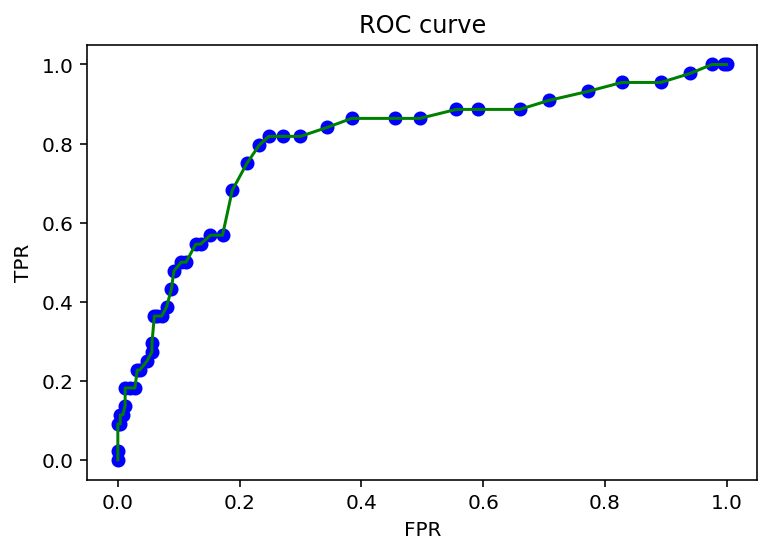

In [108]:
# 그래프도 이전 보다는 y=x에서 멀어졌다.
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### XGBClassifier

검증데이터 accuracy = 0.85   
검증데이터 auc_score = 0.80  

XGB모델로 학습을 시킨 후, 검증데이터로 성능을 확인한 결과, auc_score가 이전보다 높아졌다.   
파라미터 튜닝을 통하여 성능을 더 개선시켜보고자 한다.

In [109]:
from xgboost import XGBClassifier

# 인코딩

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train) # 학습데이터
X_val_encoded = encoder.transform(X_val) # 검증데이터

# 평가세트 만들어줌
eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

# XGBoost 분류기를 학습
# 클래스 비율을 맞추기 위해 scale_pos_weight= 재직중인 직원들(다수) / 이직한 직원들
model = XGBClassifier(n_estimators=1000
                      , max_depth=7
                      , learning_rate=0.2
                      , verbosity=0
                      , n_jobs=-1
                      , scale_pos_weight=ratio)

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='auc', 
          early_stopping_rounds=30)


[0]	validation_0-auc:0.961401	validation_1-auc:0.747545
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.982741	validation_1-auc:0.723636
[2]	validation_0-auc:0.983222	validation_1-auc:0.733773
[3]	validation_0-auc:0.990332	validation_1-auc:0.743273
[4]	validation_0-auc:0.991824	validation_1-auc:0.746818
[5]	validation_0-auc:0.994244	validation_1-auc:0.7565
[6]	validation_0-auc:0.997075	validation_1-auc:0.762227
[7]	validation_0-auc:0.998027	validation_1-auc:0.755682
[8]	validation_0-auc:0.998929	validation_1-auc:0.761682
[9]	validation_0-auc:0.999346	validation_1-auc:0.761409
[10]	validation_0-auc:0.999821	validation_1-auc:0.766045
[11]	validation_0-auc:0.999911	validation_1-auc:0.779182
[12]	validation_0-auc:0.99997	validation_1-auc:0.779364
[13]	validation_0-auc:0.99998	validation_1-auc:0.787182
[14]	validation_0-auc:0.99999	validation_1-auc:0.791091
[15

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=5.533333333333333,
              seed=None, silent=None, subsample=1, verbosity=0)

In [110]:
print('검증 정확도', model.score(X_val_encoded, y_val))

검증 정확도 0.8571428571428571


In [111]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.8092727272727274


Text(0, 0.5, 'TPR')

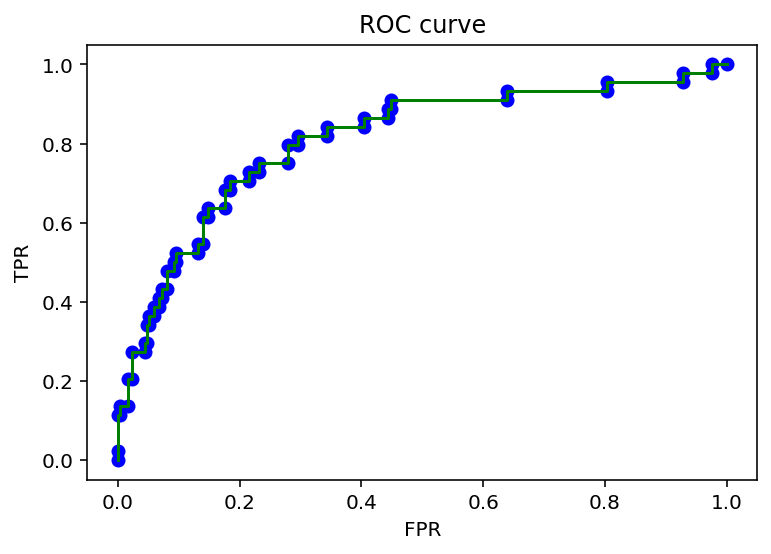

In [112]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

In [113]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    model, # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용
#X_train_encoded = pipe.named_steps['ordinalencoder'].fit_transform(X_train, y_train)
#X_val_encoded = pipe.named_steps['ordinalencoder'].transform(X_val)

# 스코어를 다시 계산
permuter.fit(X_val_encoded, y_val);

In [114]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

MaritalStatus             -0.002873
Gender                    -0.001345
TotalWorkingYears          0.000000
PerformanceRating          0.000000
YearsSinceLastPromotion    0.000000
DistanceFromHome           0.000000
YearsWithCurrManager       0.000000
YearsInCurrentRole         0.000000
YearsAtCompany             0.000000
PercentSalaryHike          0.001109
TrainingTimesLastYear      0.001855
JobLevel                   0.001982
Education                  0.003545
EducationField             0.004291
YearsAtCompany_Of_Total    0.006291
BusinessTravel             0.006309
WorkLifeBalance            0.008145
NumCompaniesWorked         0.009236
AverageWorkingYears        0.010673
JobInvolvement             0.012145
Department                 0.014891
JobRole                    0.018400
StockOptionLevel           0.022073
Age                        0.027455
MonthlyIncome              0.032236
OverallSatisfaction        0.039800
OverTime                   0.055273
dtype: float64

In [115]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 함
)

In [116]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (882, 27) (294, 27)


In [117]:
minimum_importance = 0
mask = permuter.feature_importances_ >= minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]

In [118]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (882, 25) (294, 25)


### 2-2.XGBClassifier 파라미터 튜닝

In [119]:
# 모듈을 불러오고, 하이퍼파라미터 설정함
# ordinalencoder에서 targetencoder로 변경
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV


pipe = make_pipeline(
    OrdinalEncoder(), 
    XGBClassifier(random_state=2 ,scale_pos_weight=ratio)
)

dists = {
    'xgbclassifier__n_estimators': randint(50, 1000), 
    'xgbclassifier__max_depth': [5, 7, 9], 
    'xgbclassifier__max_features': uniform(0, 1), # 0부터 1사이의 임의의 float으로 max_features 설정
    'xgbclassifier__learning_rate': [0.05, 0.1, 0.2]
}

clf = RandomizedSearchCV(
    pipe, 
		random_state=2,
    param_distributions=dists, 
    n_iter=20, 
    cv=5, 
    scoring='roc_auc',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train_selected, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   52.7s finished


In [120]:
# 최적의 하이퍼 파라미터와 그때의 성능을 확인
print('최적 하이퍼파라미터: ', clf.best_params_)
print('auc_score: ', clf.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 9, 'xgbclassifier__max_features': 0.3674713686238469, 'xgbclassifier__n_estimators': 543}
auc_score:  0.7482899991714309


In [121]:
# 가장 성능이 좋은 모델을 최종모델로 선정하여, 테스트데이터로 이의 성능을 확인함
pipe = clf.best_estimator_

In [122]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(pipe, X_train_selected, y_train, cv=5))

[0.84745763 0.84180791 0.82954545 0.83522727 0.86363636]


In [123]:
print('검증 정확도: ', pipe.score(X_val_selected, y_val))

검증 정확도:  0.8673469387755102


In [124]:
y_pred_proba = pipe.predict_proba(X_val_selected)[:, 1]
auc_score = roc_auc_score(y_val, y_pred_proba)
# roc_auc_score(실제 라벨, 학습으로 계산된 예측확률)
auc_score
# 모델에 대한 AUC Score 클수록 성능이 좋다고 할 수 있음, 이전보다 auc score 높아짐

0.8102727272727274

Text(0, 0.5, 'TPR')

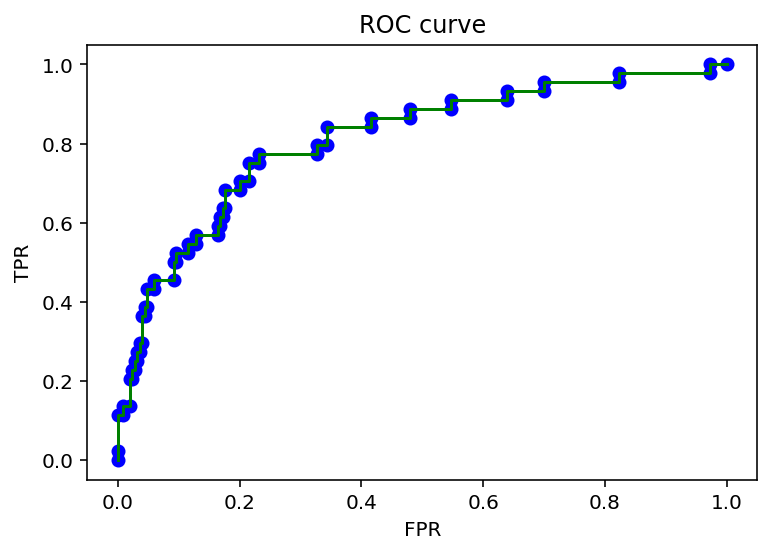

In [125]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### 11) 기준모델과 최종모델의 성능 비교

In [126]:
# 모델학습 후의 accuracy는 0.86으로, 기준모델의 accuracy인 0.84보다 높게 나왔다.

### 12) Test data로 최종모델 성능 확인

In [127]:
X_test_selected = X_test[features]

In [128]:
print('테스트 정확도: ', pipe.score(X_test_selected, y_test))

테스트 정확도:  0.826530612244898


In [129]:
y_pred_proba = pipe.predict_proba(X_test_selected)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
# roc_auc_score(실제 라벨, 학습으로 계산된 예측확률)
auc_score
# 모델에 대한 AUC Score 클수록 성능이 좋다고 할 수 있음

0.7880625365283459

Text(0, 0.5, 'TPR')

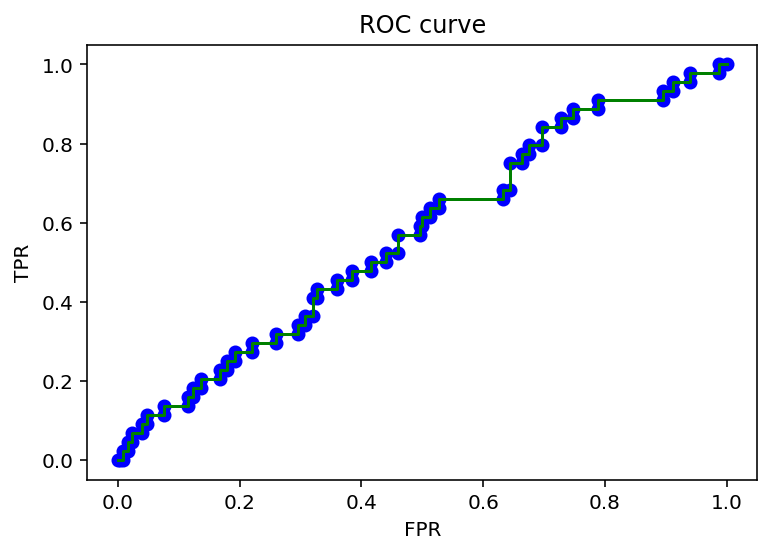

In [130]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

plt.scatter(fpr, tpr, color='blue')
plt.plot(fpr, tpr, color='green')
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')

### 13) 모델의 성능 개선을 위한 시도

In [131]:
# Decision tree를 사용해 모델을 만들었을 때에는 accuracy가 기준모델을 넘지 못하여 Randomforest를 적용해 보았다. 
# Randomforest를 사용하였을 때는 기준모델의 성능을 넘었지만, 해당 문제의 평가지표로 지정한 auc_score를 높이기 위하여
# XGB모델을 만들어서 RandomizedsearchCV로 파라미터 튜닝을 하며 성능을 개선하였다.

### 14) 최종모델 설명

In [132]:
# Permutation Importance를 확인하여 타겟의 예측이 도움이 되지 않는 음수의 영향력을 가지는 특성들을 삭제 후에, 파라미터 튜닝을 하여 최종모델로 정하였다.
# Ordinal Encoder를 사용하였으며 XGB로 모델을 학습 시켰다. 과적합을 방지하기 위해 learning rate, max_depth 낮은 수준으로 지정.
# 최적 하이퍼파라미터: 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 9, 'xgbclassifier__max_features': 0.3674713686238469, 'xgbclassifier__n_estimators': 543}

In [133]:
# 검증데이터의 accuracy는 0.86이 나왔고, AUC score는 0.81이 나왔다.

In [134]:
# 테스트데이터의 accuracy는 0.82가 나왔고, AUC score는 0.78로 검증데이터 보다 낮다.

In [135]:
# 최종모델의 Permutation Importance

In [136]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['xgbclassifier'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용
X_train_encoded = pipe.named_steps['ordinalencoder'].fit_transform(X_train_selected, y_train)
X_val_encoded = pipe.named_steps['ordinalencoder'].transform(X_val_selected)

# 스코어를 다시 계산
permuter.fit(X_val_encoded, y_val);

In [137]:
feature_names = X_val_selected.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

Education                 -0.005036
NumCompaniesWorked        -0.001418
DistanceFromHome           0.000000
YearsWithCurrManager       0.000000
YearsSinceLastPromotion    0.000000
YearsInCurrentRole         0.000000
PerformanceRating          0.000000
YearsAtCompany             0.000000
TotalWorkingYears          0.000000
PercentSalaryHike          0.000473
EducationField             0.003873
AverageWorkingYears        0.004782
Department                 0.006073
JobInvolvement             0.006891
YearsAtCompany_Of_Total    0.006982
BusinessTravel             0.007564
Age                        0.012164
TrainingTimesLastYear      0.012345
JobLevel                   0.012727
WorkLifeBalance            0.016564
OverallSatisfaction        0.019382
JobRole                    0.021345
StockOptionLevel           0.038055
MonthlyIncome              0.042764
OverTime                   0.054600
dtype: float64

In [138]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 함
)

In [139]:
X_val_selected

Age     BusinessTravel  ... YearsAtCompany_Of_Total OverallSatisfaction
563    25      Travel_Rarely  ...                    1.00                   9
296    18      Travel_Rarely  ...                    0.00                   9
1468   49  Travel_Frequently  ...                    0.52                  10
225    59      Travel_Rarely  ...                    0.14                   8
618    25      Travel_Rarely  ...                    0.66                   5
...   ...                ...  ...                     ...                 ...
1351   48  Travel_Frequently  ...                    0.91                  10
1258   29      Travel_Rarely  ...                    1.00                   8
385    30  Travel_Frequently  ...                    0.33                  10
1147   49      Travel_Rarely  ...                    0.90                   8
1440   36  Travel_Frequently  ...                    0.22                   8

[294 rows x 25 columns]

In [140]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=5, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 함
)

In [141]:
enc = pipe.named_steps['ordinalencoder']
X_train_selected = enc.fit_transform(X_train_selected,y_train)
X_val_selected = enc.transform(X_val_selected)

In [142]:
# PDP 시각화
from pdpbox.pdp import pdp_isolate
from pdpbox.pdp import pdp_plot

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83ba081c50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83f73f9c10>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


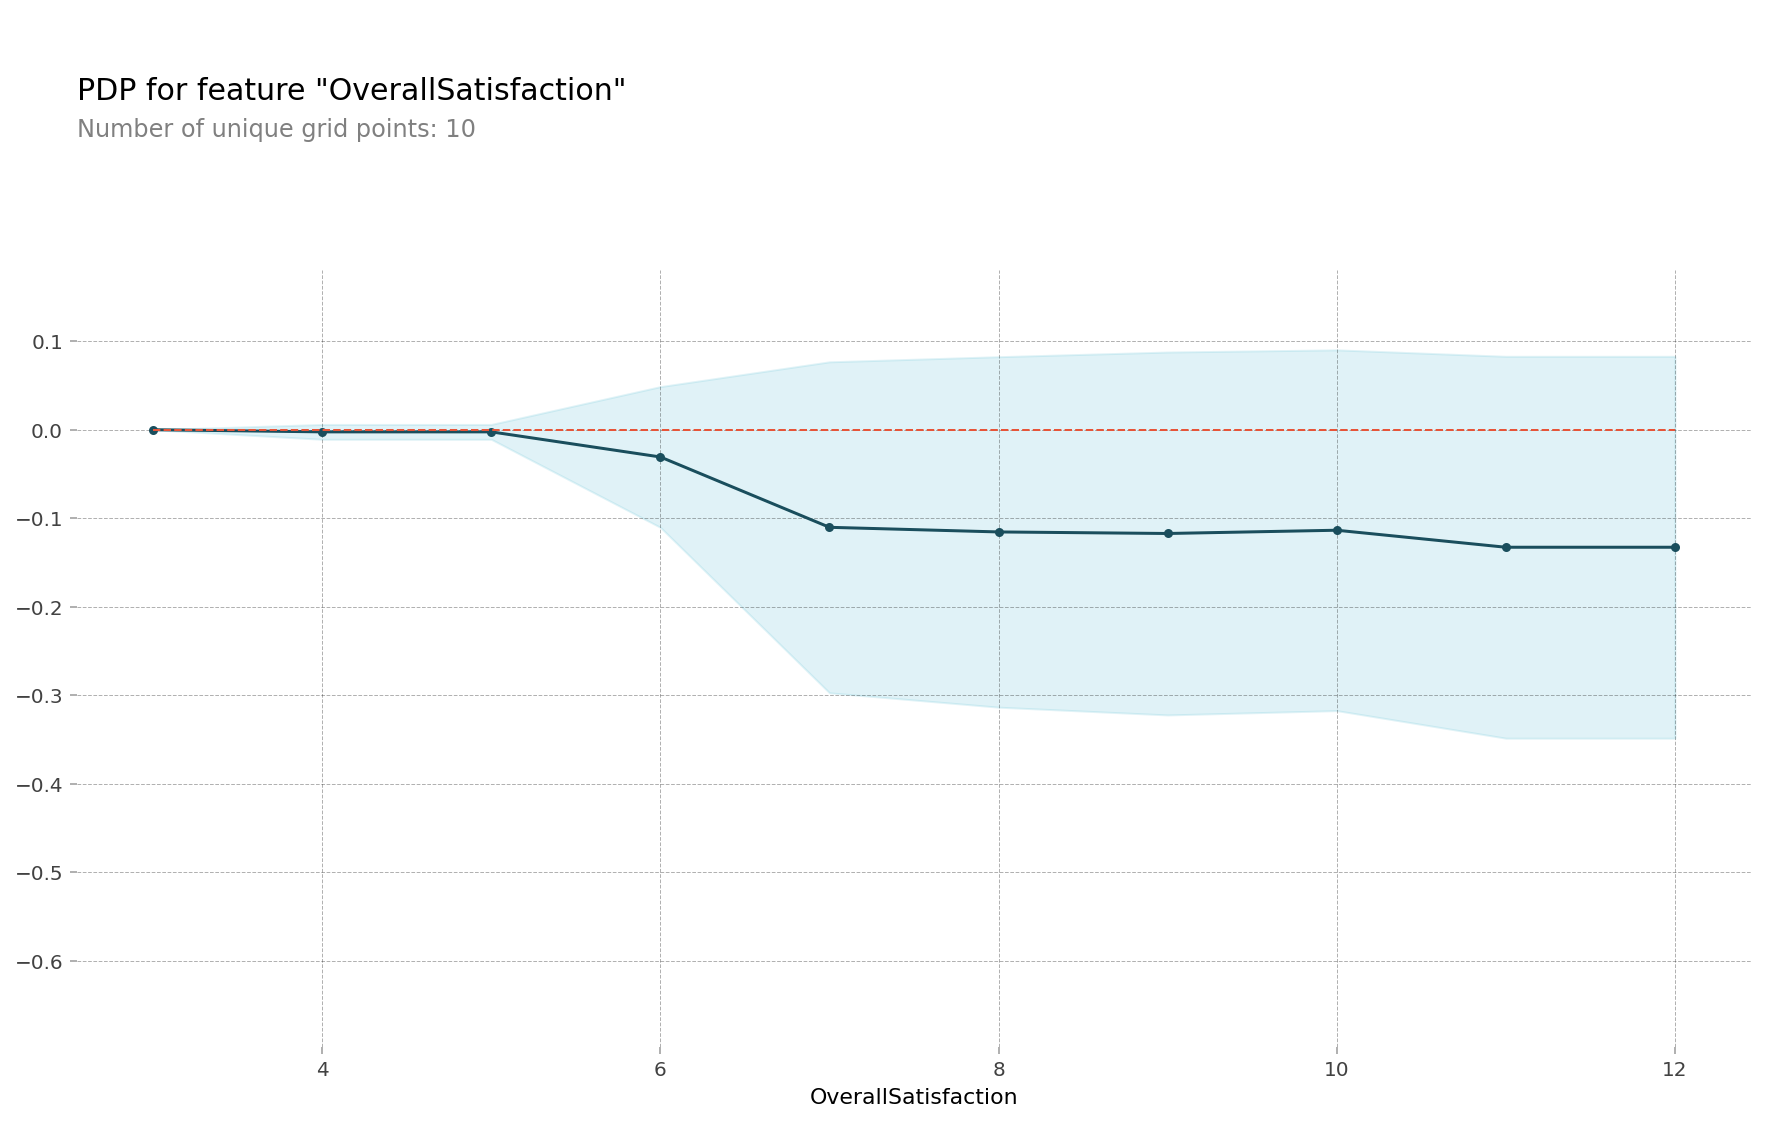

In [143]:
feature = 'OverallSatisfaction'

pdp_dist = pdp_isolate(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , feature=feature
    , grid_type='equal'
    , num_grid_points=10)

pdp_plot(pdp_dist, feature)

In [144]:
# OverallSatisfaction은 3~12로 나뉘어진 직원의 회사에 대한 전반적인 만족도에 관한 설문조사 항목이다.
# 만족도가 12에 가까울 수록 현재 회사에 만족하고 있는 해석할 수 있다.
# 모델은 만족도가 증가함에 따라 직원이 이직을 할 가능성이 낮다고 예측한다.

In [145]:
feature = 'OverTime'

# PDP isolate 계산
pdp_dist = pdp_isolate(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , feature=feature
    , grid_type='equal'
    , num_grid_points=10)

In [146]:
# 인코딩 매핑확인
encoder = pipe.named_steps['ordinalencoder']
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

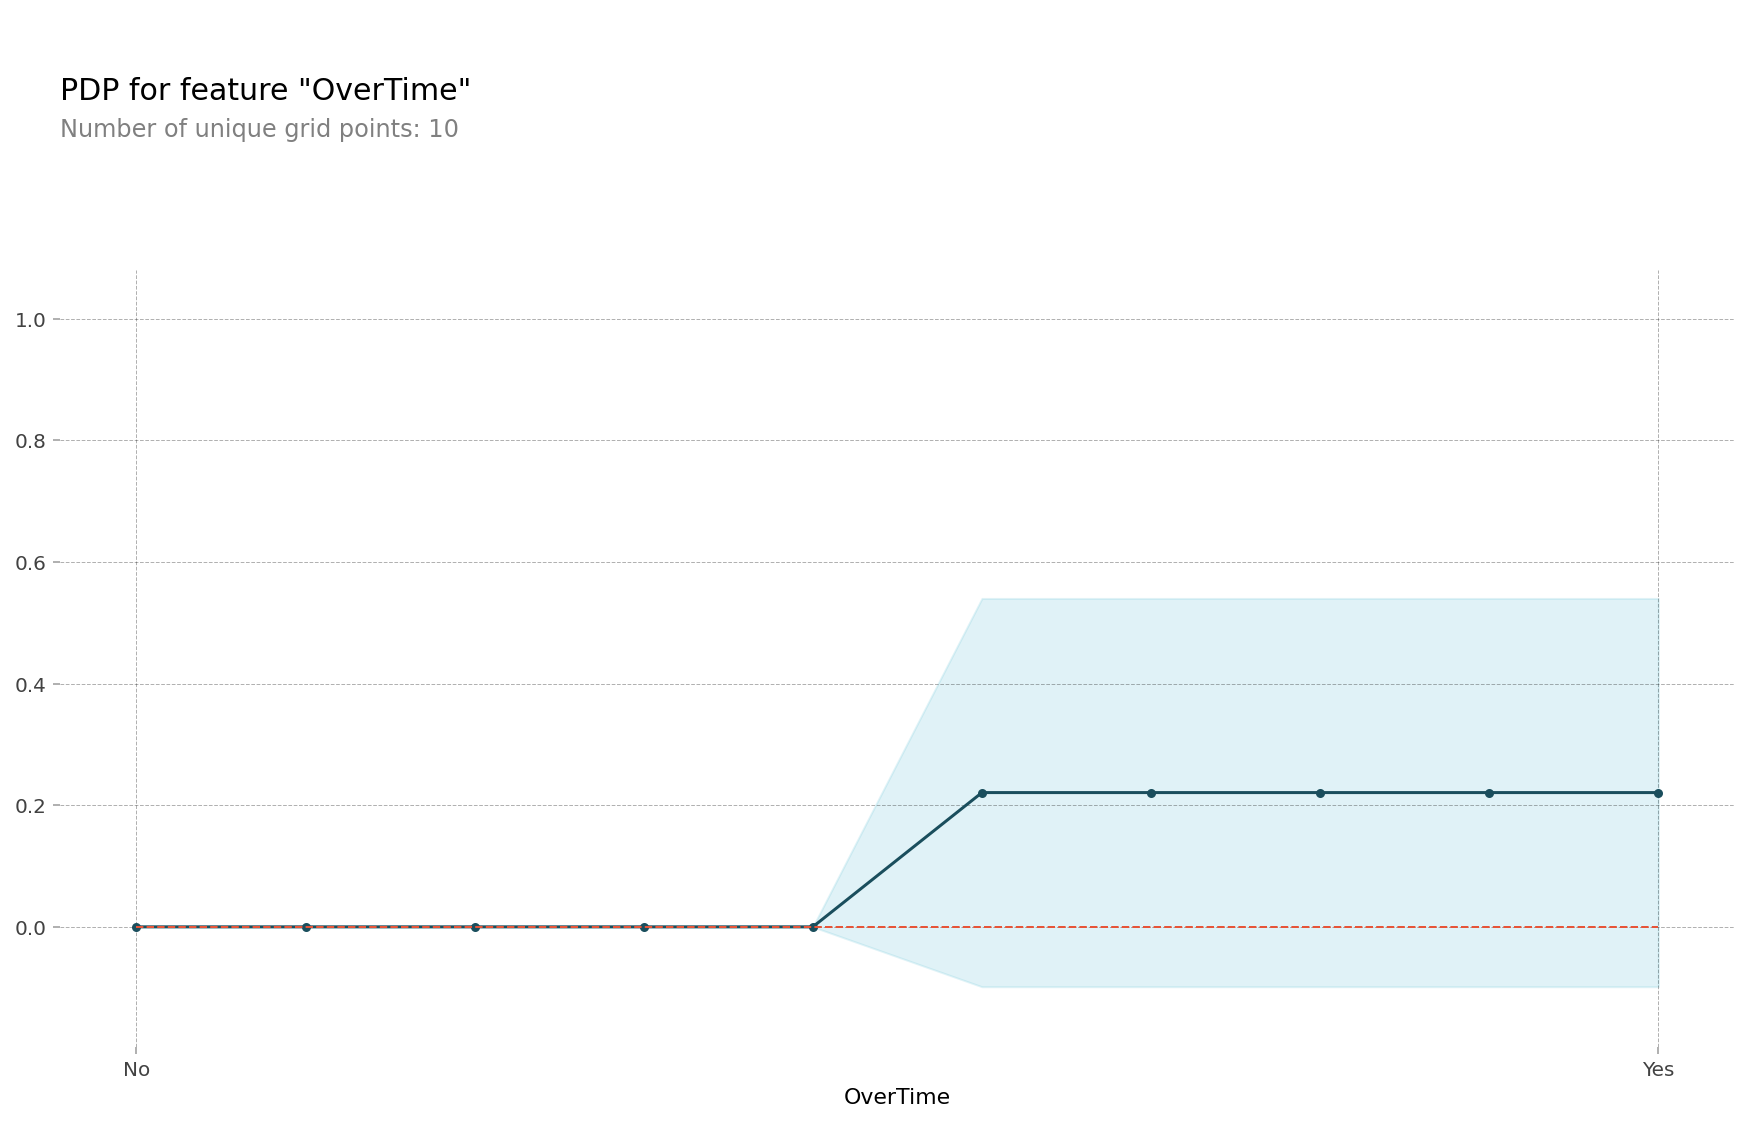

In [147]:
# 인코딩 전 이름으로 PDP plot 시각화
pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names);

In [148]:
# overtime은 초과근무 여부에 대한 항목이다.
# 초과근무가 자발적인 것인지, 얼마나 자주 초과근무를 하는지는 알 수 없지만, 모델은 초과근무를 하는 직원일 때 이직을 할 가능성이 높다고 예측한다.

In [149]:
feature = 'JobRole'

# PDP isolate 계산
pdp_dist = pdp_isolate(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , feature=feature
    , grid_type='equal'
    , num_grid_points=10)

In [150]:
# 인코딩 매핑확인
encoder = pipe.named_steps['ordinalencoder']
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping'] # Series
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


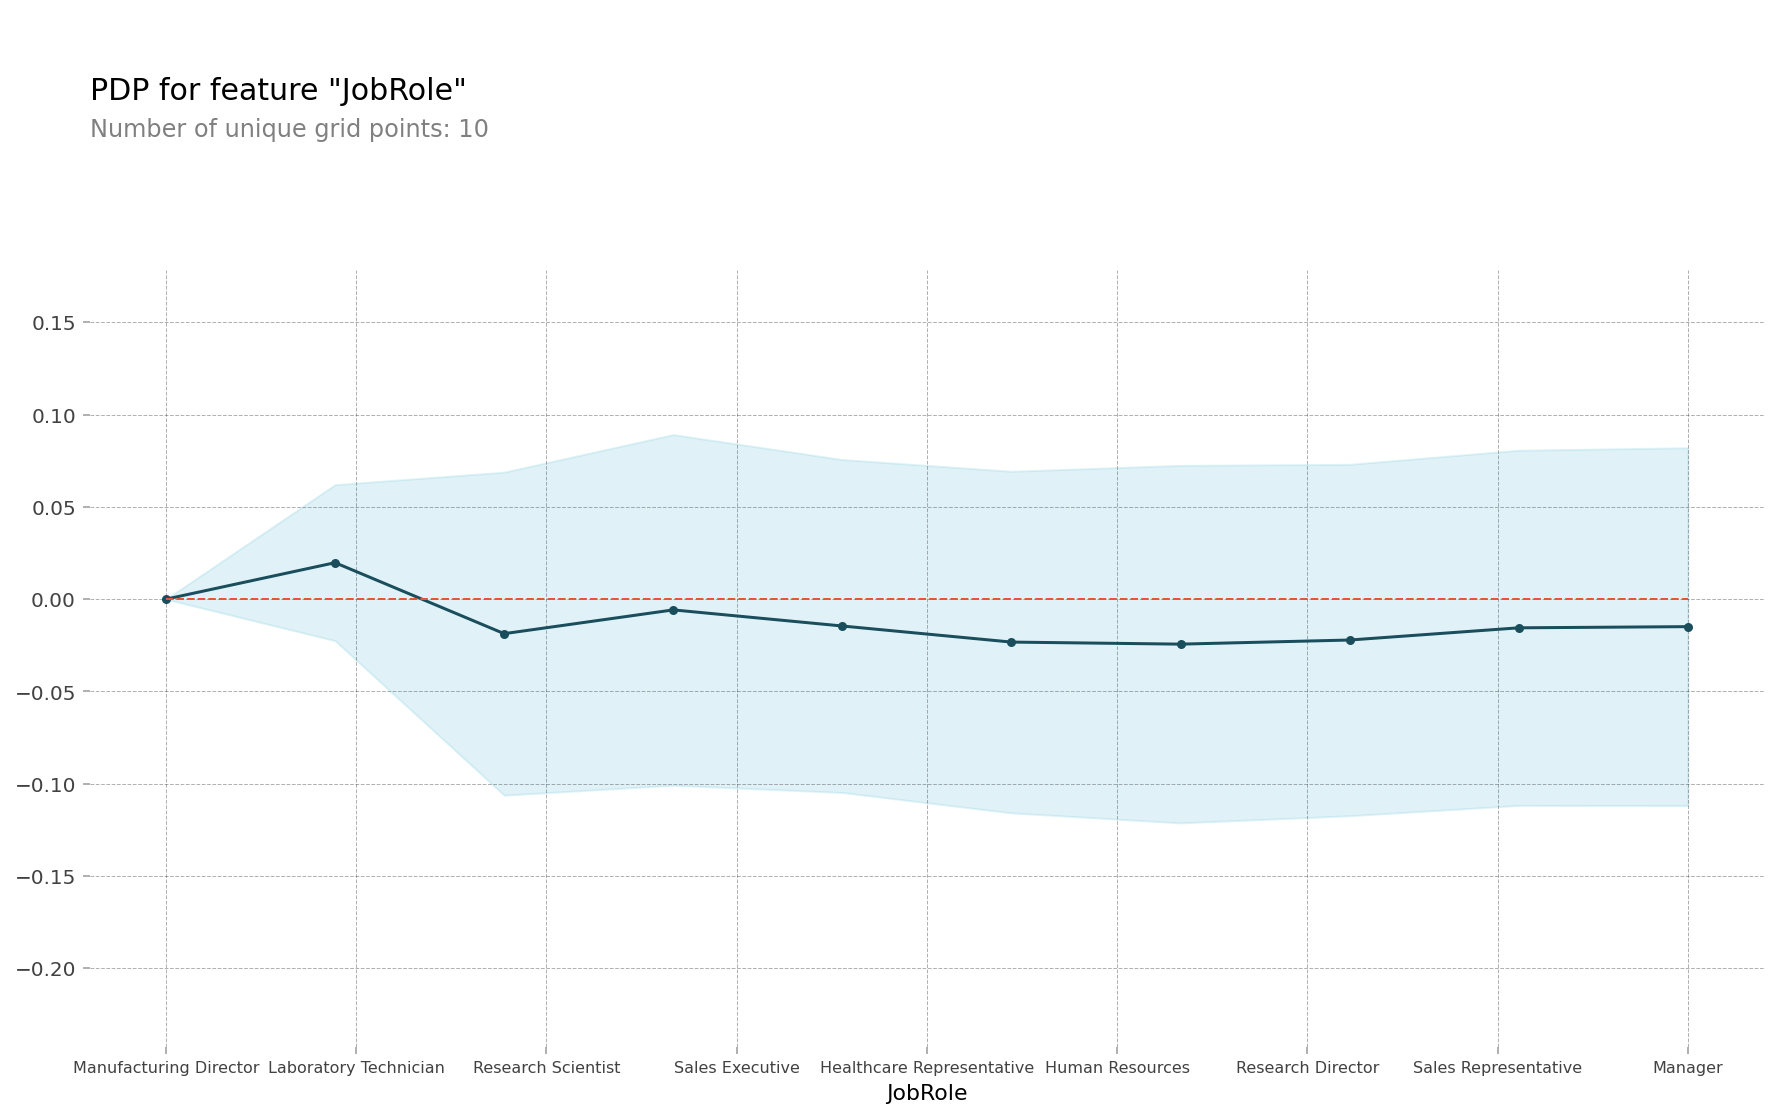

In [151]:
# 인코딩 전 이름으로 PDP plot 시각화
pdp_plot(pdp_dist, feature)

# xticks labels 설정을 위한 리스트를 직접 넣지 않아도 됩니다 
plt.xticks(category_codes, category_names, fontsize=8);

In [152]:
# 모델은 직원의 직무 역할에 따라 이직 가능성을 다르게 예측한다.
# 이직 가능성이 가장 높다고 예측하는 것은 Laboratory Technician이다.

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83b9df7710>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83b9e3f4d0>})

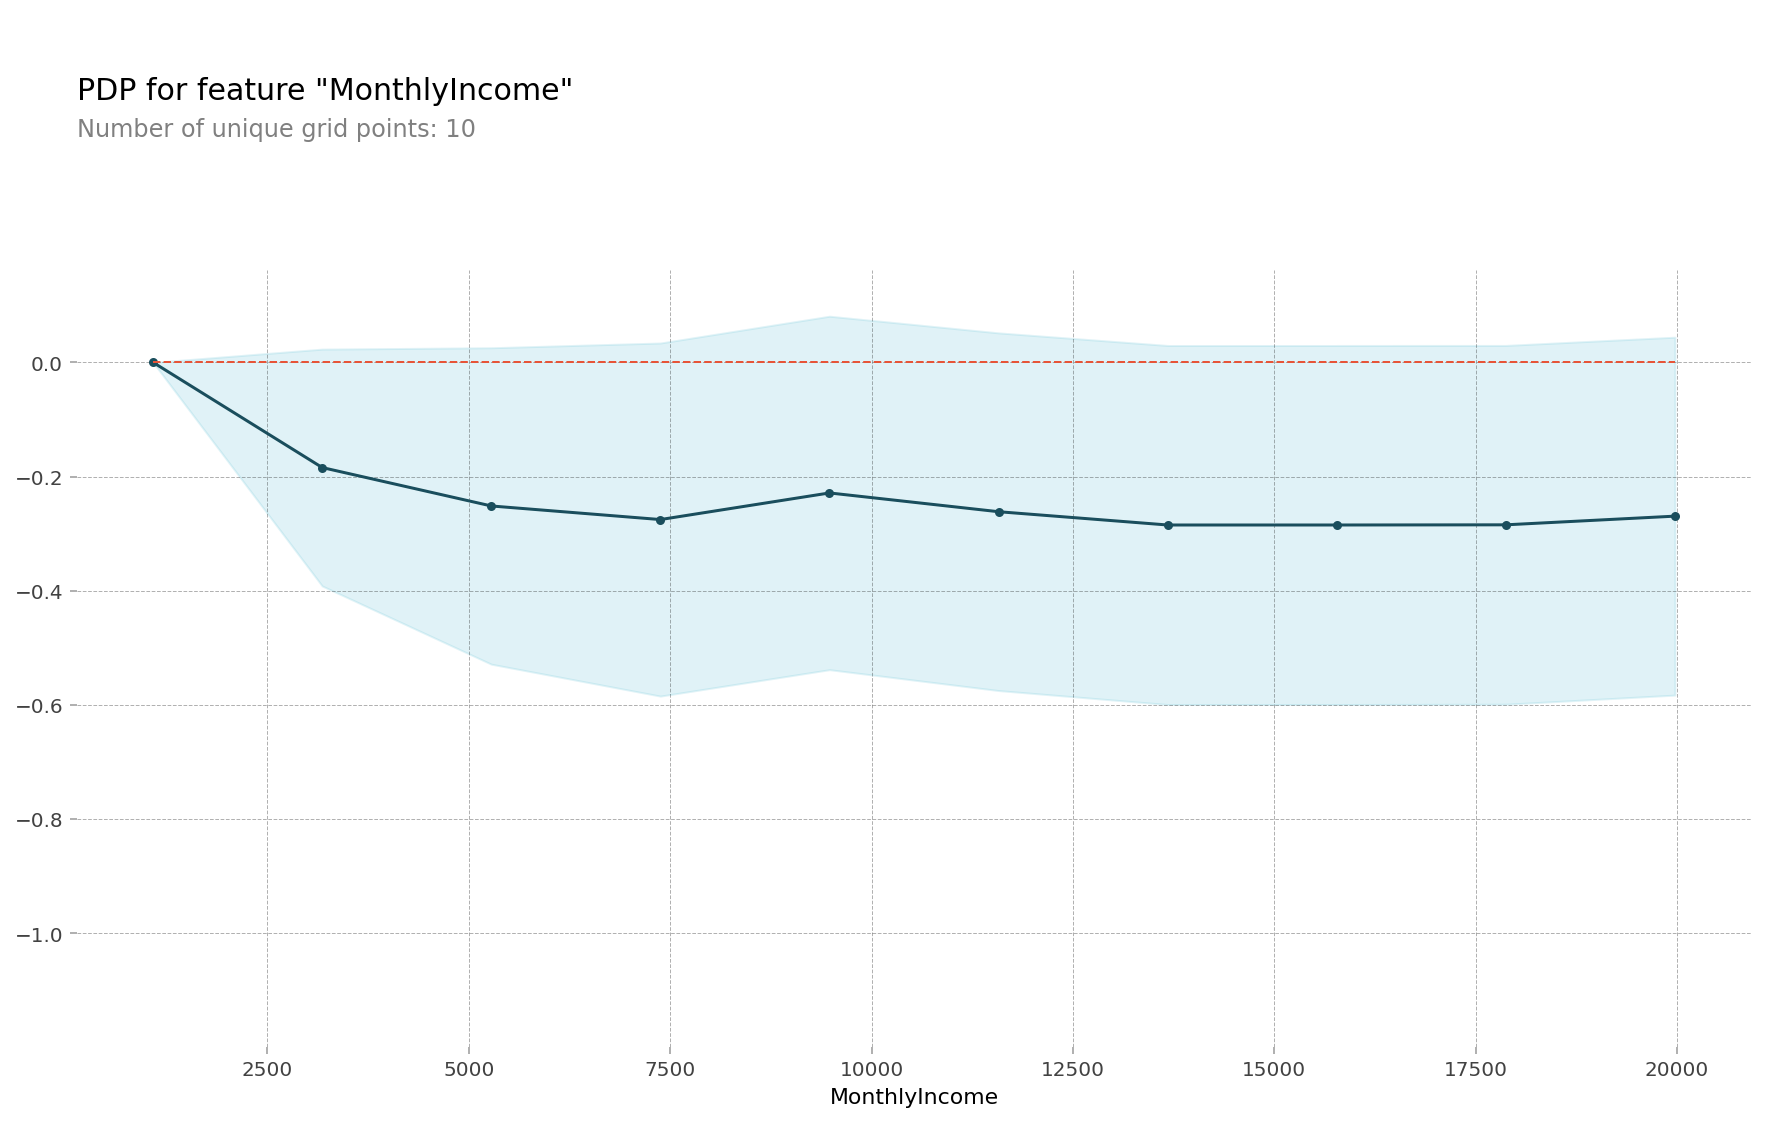

In [153]:
feature = 'MonthlyIncome'

pdp_dist = pdp_isolate(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , feature=feature
    , grid_type='equal'
    , num_grid_points=10)

pdp_plot(pdp_dist, feature)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83b9d8c990>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83b9e3f710>})

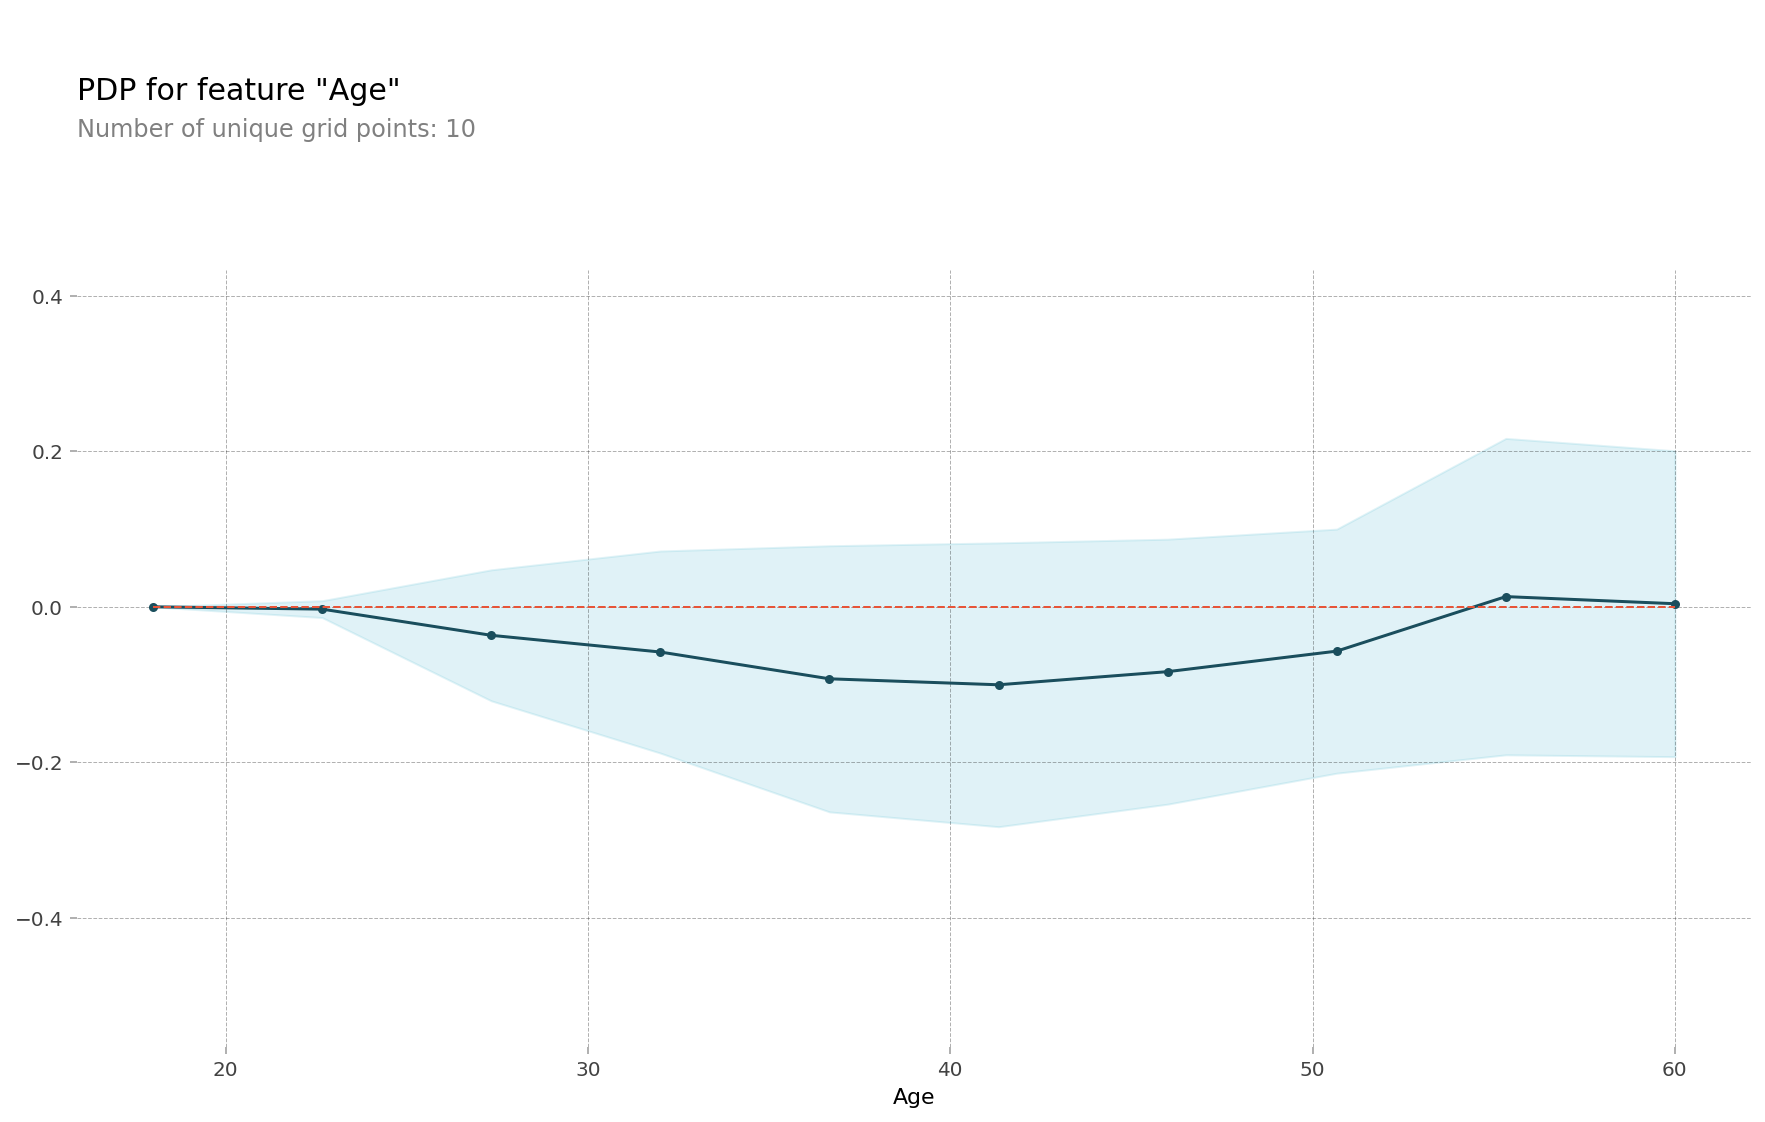

In [155]:
feature = 'Age'

pdp_dist = pdp_isolate(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , feature=feature
    , grid_type='equal'
    , num_grid_points=10)

pdp_plot(pdp_dist, feature)

In [156]:
# 모델은 20-30대로 갈수록 이직을 할 확률이 줄어드는 것으로 예측하며, 30-50대에는 이직할 확률이 다른 연령대 보다 낮다고 예측한다.
# 모델은 50대 중후반에 이직확률이 높은 것으로 예측하는데, 이는 다른 회사로의 이직이라기 보다는 정년 퇴직전의 조기퇴직 사례로 영향을 받았다고 판단된다. 

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83b9cd6f50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f83b9cdeb90>})

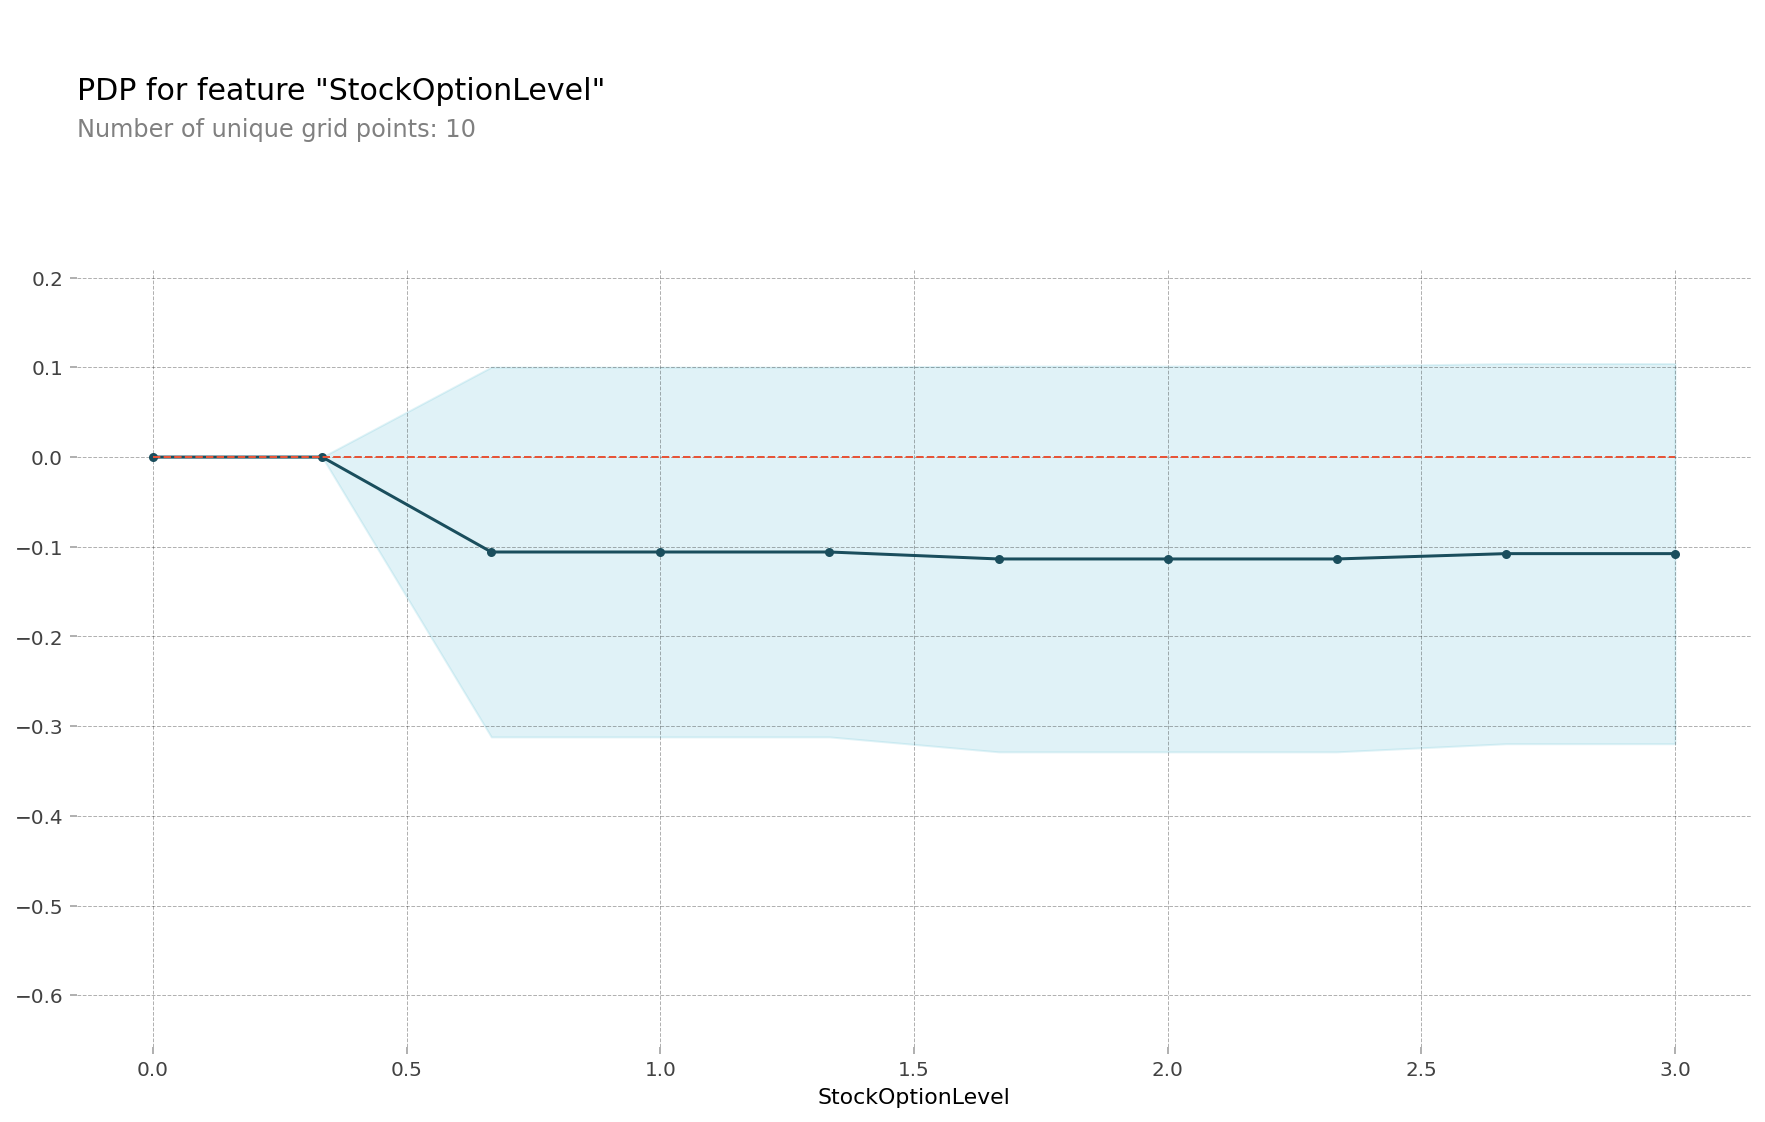

In [157]:
feature = 'StockOptionLevel'

pdp_dist = pdp_isolate(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , feature=feature
    , grid_type='equal'
    , num_grid_points=10)

pdp_plot(pdp_dist, feature)

In [158]:
# 모델은 직원이 스톡옵션이 아예 없을때(0) 보다 하나라도 있을 때, 이직을 할 확률이 낮다고 예측한다. (이직율이 레벨에 비례하지는 않는다.)
# 스톡옵션 행사라는 추가적인 경제적 보상이 있을 때, 이직을 할 확률이 낮음을 확인할 수 있다.

In [159]:
from pdpbox.pdp import pdp_interact 
from pdpbox.pdp import pdp_interact_plot 

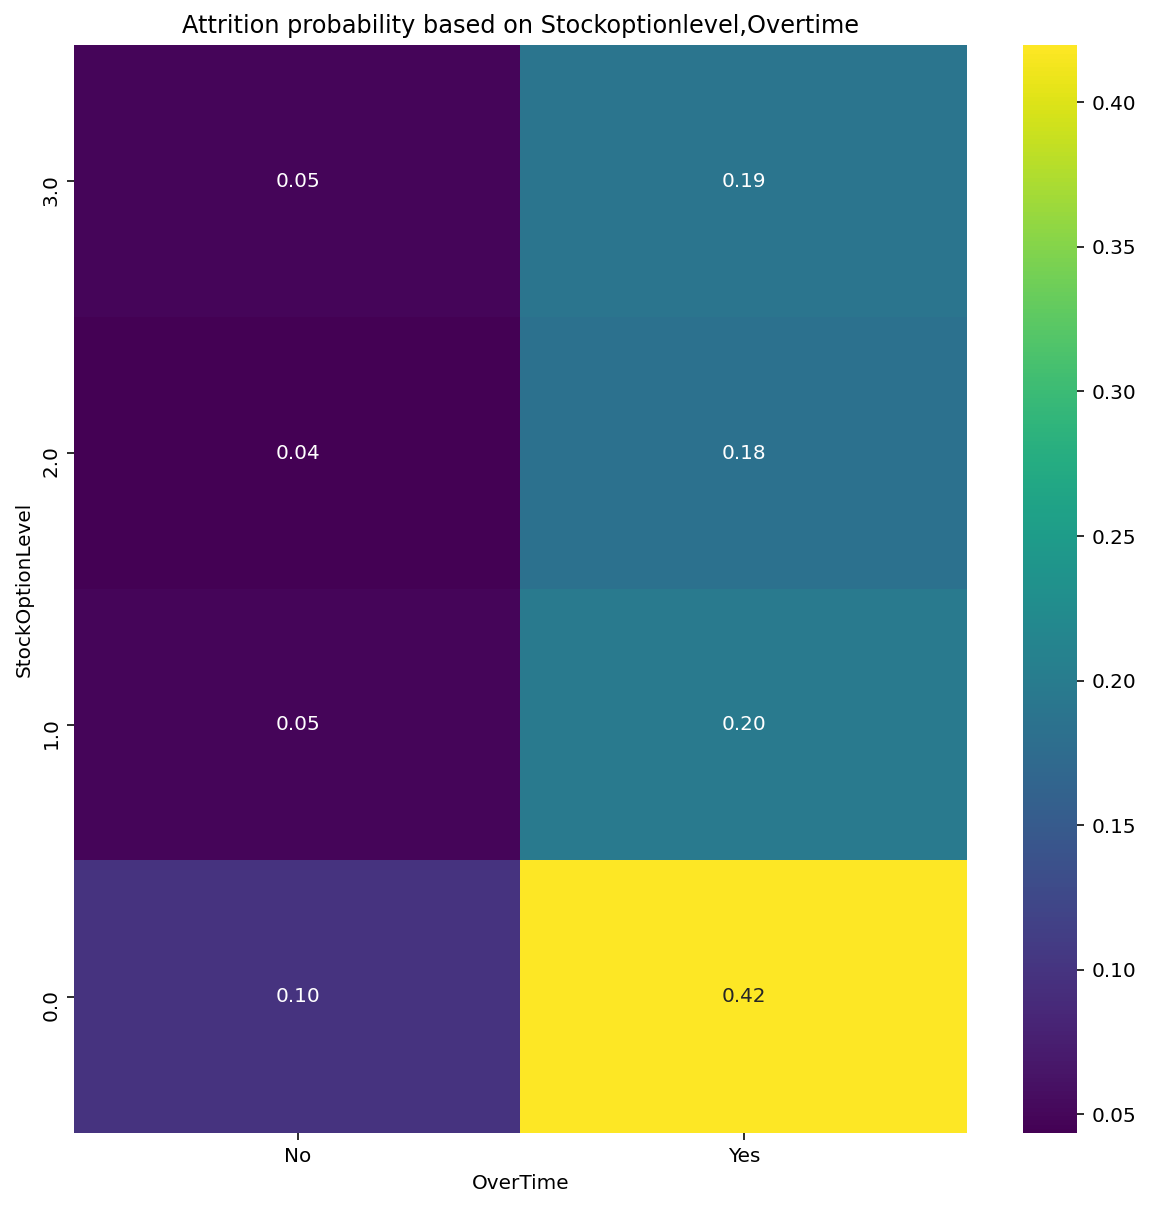

In [160]:
features = ['OverTime', 'StockOptionLevel']

# 두 특성의 상호작용 확인하기 위한 데이터 불러오기
interaction = pdp_interact(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , features=features   # 상호작용 확인하고자 하는 두가지 특성
)

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns={1.0:'No',2.0:'Yes'})
plt.figure(figsize=(10,10))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Attrition probability based on Stockoptionlevel,Overtime');

In [161]:
# 초과근무와 스톡옵션 레벨에 따른 이직확률
# 초과근무를 하지 않는 직원은 스톡옵션이 없더라도 이직을 할 확률이 0.1에 그치지 않지만, 초과근무를 하는 직원의 경우 0.42로 이직할 확률이 상당히 높다.
# 초과근무를 하는 직원은 스톡옵션을 가지고 있더라도, 초과근무를 하지 않는 스톡옵션이 없는 사람에 비해 이직을 할 확률이 1.8배이상 높다.
# 회사차원에서 직원에게 스톡옵션을 지급기 어려운 경우에는 최소한 해당 직원에게 초과근무는 하지 않도록 하는 것이 이직을 효과적으로 방지할 수 있는 방법이다.

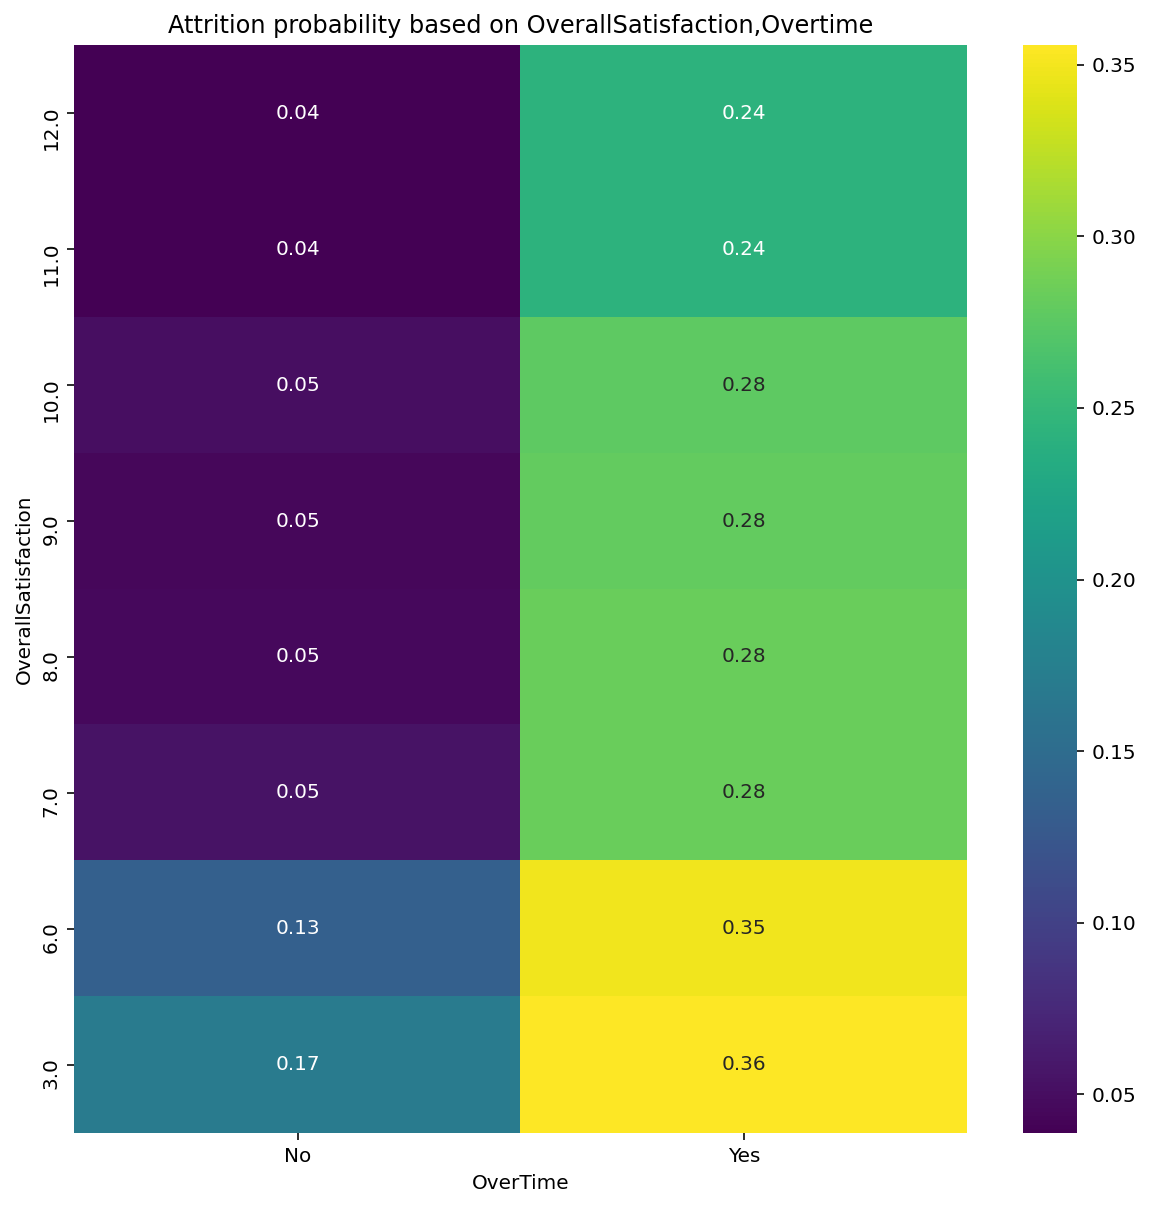

In [162]:
features = ['OverTime', 'OverallSatisfaction']

# 두 특성의 상호작용 확인하기 위한 데이터 불러오기
interaction = pdp_interact(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , features=features   # 상호작용 확인하고자 하는 두가지 특성
)

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns={1.0:'No',2.0:'Yes'})
plt.figure(figsize=(10,10))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Attrition probability based on OverallSatisfaction,Overtime');

In [163]:
# 초과근무와 전반적인 만족도에 따른 이직확률
# 초과근무를 하며 전반적 만족도가 6.5점 이하인 직원들은 이직을 할 확률이 높다.
# 초과근무를 하며 전반적인 만족도가 11,12로 높은 직원들이 이직을 할 확률이 초과근무를 하지 않으나 만족도가 3인 직원들 보다도 높다.
# 초과근무에 대한 대안책을 마련해야 할 것으로 보인다. 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


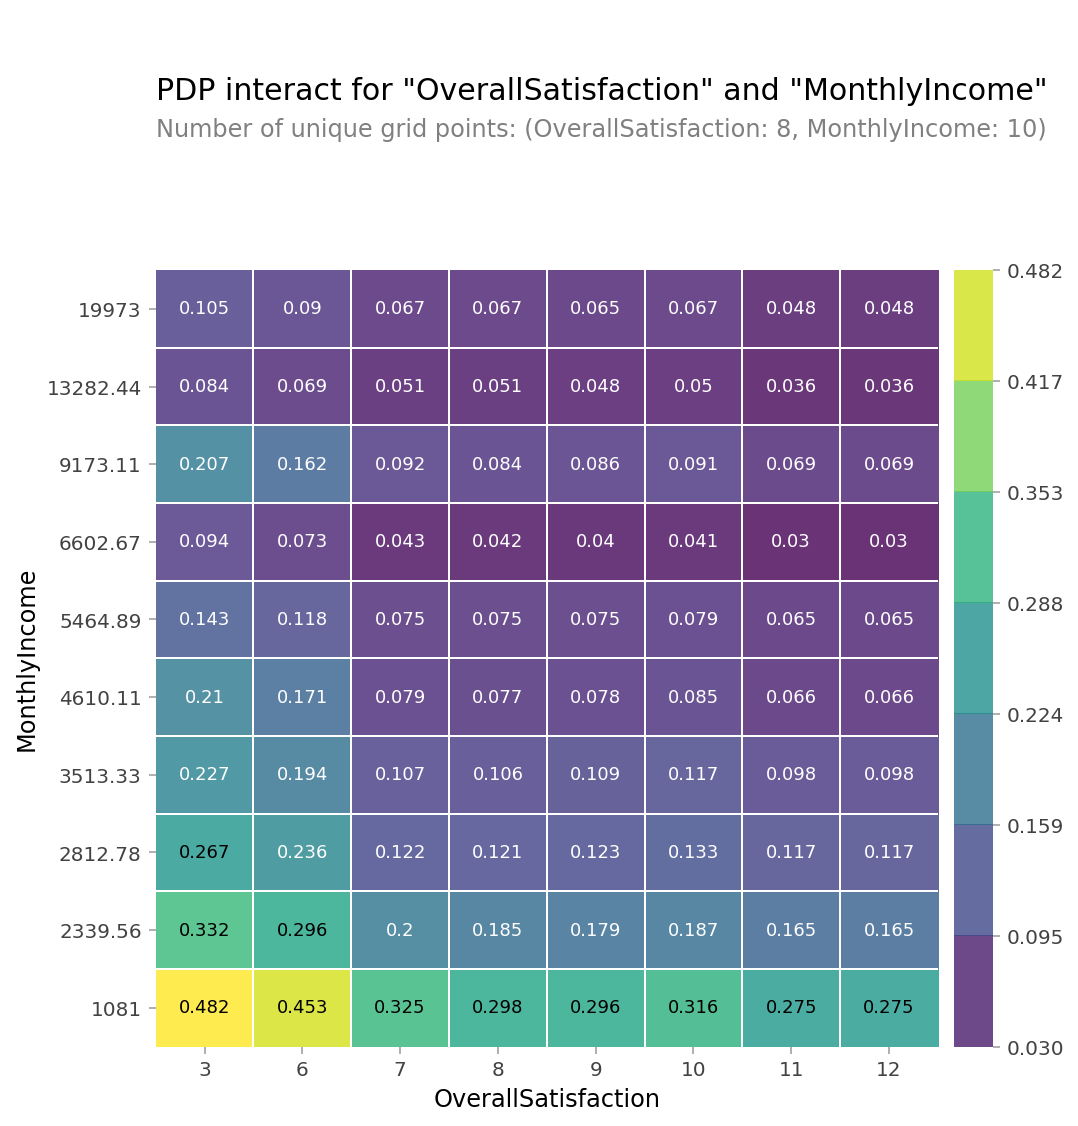

In [164]:
features = ['OverallSatisfaction', 'MonthlyIncome']

# 두 특성의 상호작용 확인하기 위한 데이터 불러오기
interaction = pdp_interact(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , features=features   # 상호작용 확인하고자 하는 두가지 특성
)

pdp_interact_plot(interaction, plot_type='grid', # 그래프 타입은 grid
                  feature_names=features);

In [165]:
# 모델은 만족도가 6이하이고, 월 임금이 $2500 미만일 때 직원이 이직을 할 확률이 높아진다고 예측한다.

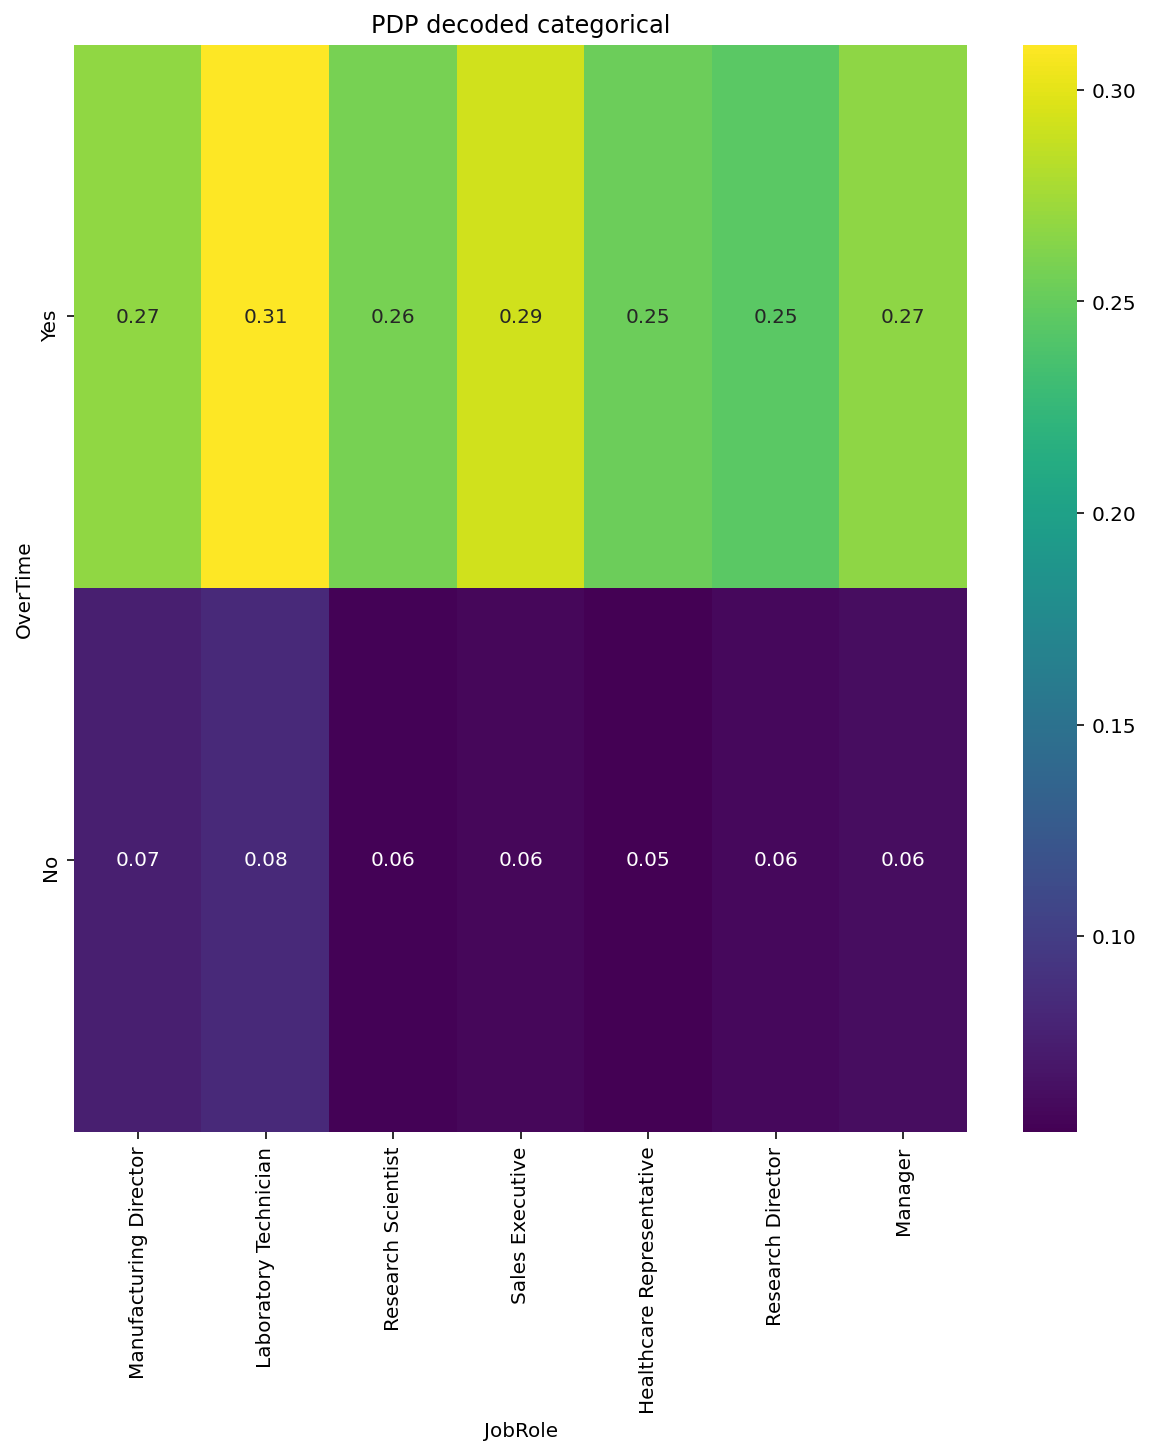

In [166]:
features = ['JobRole', 'OverTime']

# 두 특성의 상호작용 확인하기 위한 데이터 불러오기
interaction = pdp_interact(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , features=features   # 상호작용 확인하고자 하는 두가지 특성
)

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)),index={1.0:'No',2.0:'Yes'})
plt.figure(figsize=(10,10))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('PDP decoded categorical');

In [167]:
# 초과근무를 하는 경우와 하지 않는 경우에 따라 이직을 할 확률이 확연하게 차이가 난다.
# 특히나 직무역할이 Laboratory technician이고, 초과근무를 한다면 이직을 할 확률이 가장 높다고 예측한다.

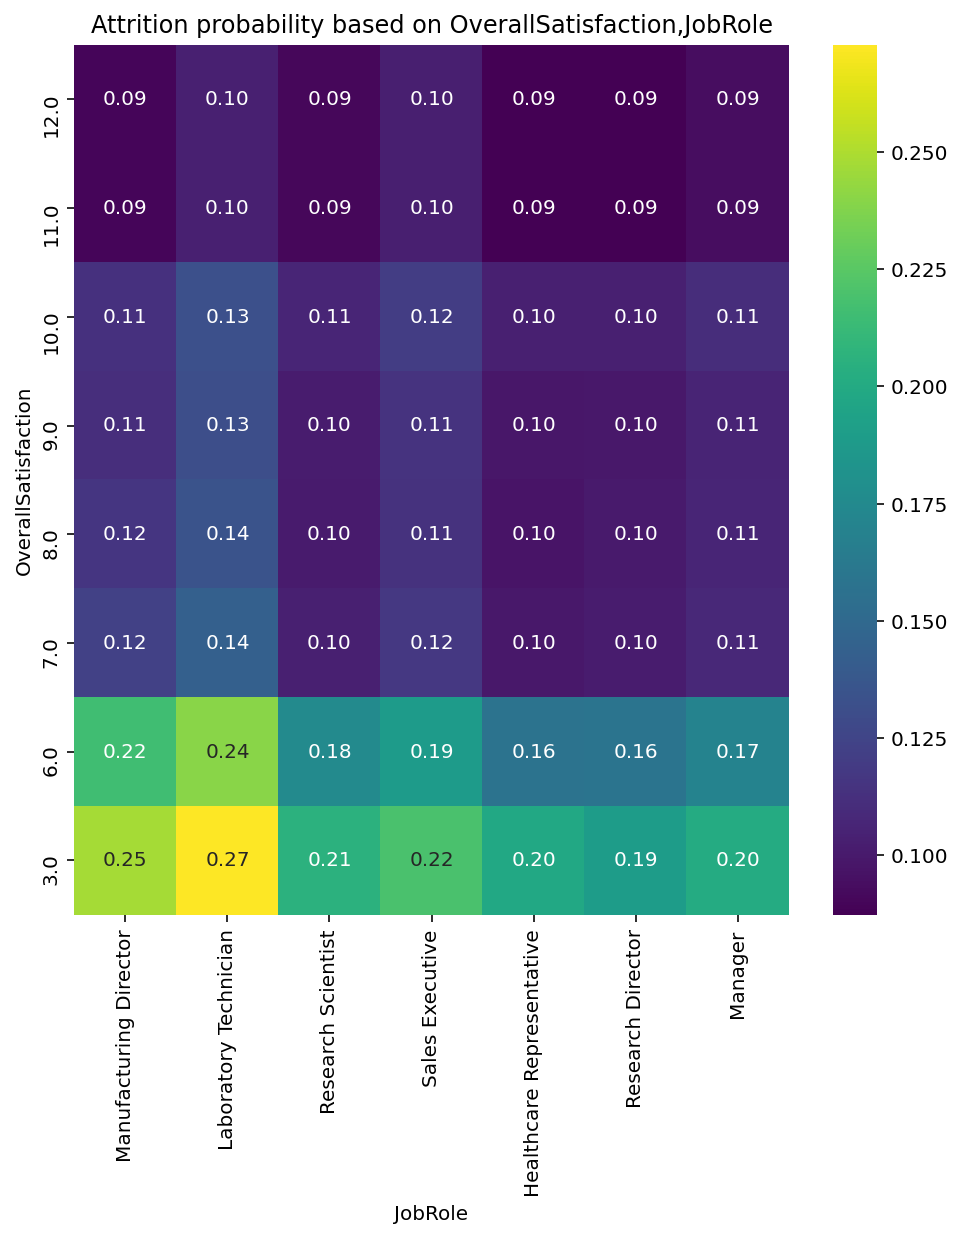

In [199]:
features = ['JobRole', 'OverallSatisfaction']

# 두 특성의 상호작용 확인하기 위한 데이터 불러오기
interaction = pdp_interact(
    model= pipe.named_steps['xgbclassifier']
    , dataset=X_val_selected
    , model_features= X_val_selected.columns
    , features=features   # 상호작용 확인하고자 하는 두가지 특성
)

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(8,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Attrition probability based on OverallSatisfaction,JobRole');

In [169]:
# 직무역할과 만족도에 따른 이직 확률을 확인한 결과, 만족도가 6이하 일때 이직을 할 가능성이 높은 직무는 Laboratory technician이다.
# Laboratory technician은 만족도가 높아지더라도 다른 직무를 맡은 직원보다 이직을 할 확률이 조금씩 높다. 해당 직무 직원의 이직을 방지하기 위한 수단이 필요하다. 

In [170]:
X_test_selected = enc.transform(X_test_selected)

In [171]:
model = pipe.named_steps['xgbclassifier']
model.classes_

array([0, 1])

In [172]:
X_test_selected

Age  BusinessTravel  ...  YearsAtCompany_Of_Total  OverallSatisfaction
1291   37               1  ...                     1.00                    7
1153   18               3  ...                     0.00                    9
720    30               1  ...                     0.71                    6
763    34               1  ...                     1.00                   10
976    56               1  ...                     0.57                    7
...   ...             ...  ...                      ...                  ...
302    28               1  ...                     0.88                    6
443    22               3  ...                     0.50                    9
701    53               1  ...                     0.77                    9
309    31               1  ...                     0.83                   10
845    40               3  ...                     0.06                   11

[294 rows x 25 columns]

In [173]:
a = X_test.reset_index()
a

index  Age  ... YearsAtCompany_Of_Total OverallSatisfaction
0     1291   37  ...                    1.00                   7
1     1153   18  ...                    0.00                   9
2      720   30  ...                    0.71                   6
3      763   34  ...                    1.00                  10
4      976   56  ...                    0.57                   7
..     ...  ...  ...                     ...                 ...
289    302   28  ...                    0.88                   6
290    443   22  ...                    0.50                   9
291    701   53  ...                    0.77                   9
292    309   31  ...                    0.83                  10
293    845   40  ...                    0.06                  11

[294 rows x 28 columns]

In [174]:
b = df.reset_index()
b

index  Age  ...  YearsAtCompany_Of_Total OverallSatisfaction
0         0   41  ...                     0.75                   7
1         1   49  ...                     1.00                   9
2         2   37  ...                     0.00                   9
3         3   33  ...                     1.00                  10
4         4   27  ...                     0.33                   7
...     ...  ...  ...                      ...                 ...
1465   1465   36  ...                     0.29                  10
1466   1466   39  ...                     0.77                   6
1467   1467   27  ...                     1.00                   6
1468   1468   49  ...                     0.52                  10
1469   1469   34  ...                     0.66                   6

[1470 rows x 29 columns]

In [175]:
b = b.rename(columns={'index':'id'})
b

id  Age  ...  YearsAtCompany_Of_Total OverallSatisfaction
0        0   41  ...                     0.75                   7
1        1   49  ...                     1.00                   9
2        2   37  ...                     0.00                   9
3        3   33  ...                     1.00                  10
4        4   27  ...                     0.33                   7
...    ...  ...  ...                      ...                 ...
1465  1465   36  ...                     0.29                  10
1466  1466   39  ...                     0.77                   6
1467  1467   27  ...                     1.00                   6
1468  1468   49  ...                     0.52                  10
1469  1469   34  ...                     0.66                   6

[1470 rows x 29 columns]

In [176]:
# test ids를 저장하고 SHAP분석시 사용합니다
test_id = a['index']

In [177]:
len(test_id), len(y_pred_proba), len(y_test)

(294, 294, 294)

In [178]:
df_p = pd.DataFrame({
    'id': a['index'].values , 
    'pred_proba': y_pred_proba, # 예측확률 
    'attririon': y_test # 실제값
})
df_p

id  pred_proba  attririon
1291  1291    0.006157          1
1153  1153    0.998397          1
720    720    0.969433          1
763    763    0.537315          0
976    976    0.030150          0
...    ...         ...        ...
302    302    0.000234          0
443    443    0.085531          1
701    701    0.001238          0
309    309    0.001779          0
845    845    0.045113          0

[294 rows x 3 columns]

In [179]:
df_p = df_p.merge(
     b[['id','OverTime','MonthlyIncome','OverallSatisfaction','StockOptionLevel']],
     how='left'
)

In [180]:
df_p.head(20)

id  pred_proba  ...  OverallSatisfaction StockOptionLevel
0   1291    0.006157  ...                    7                0
1   1153    0.998397  ...                    9                0
2    720    0.969433  ...                    6                0
3    763    0.537315  ...                   10                1
4    976    0.030150  ...                    7                1
5    724    0.001703  ...                    9                2
6    314    0.000123  ...                    8                0
7    258    0.038893  ...                    9                0
8    442    0.237096  ...                   10                0
9   1393    0.000071  ...                    9                0
10   894    0.000511  ...                    9                0
11   435    0.001972  ...                    9                0
12   952    0.996569  ...                    7                0
13   236    0.048879  ...                    3                0
14  1170    0.043277  ...                   11                0
15  1295    0.003037  ...                   10                1
16   826    0.000854  ...                   10                1
17   453    0.889911  ...                    7                1
18  1230    0.021103  ...                    5                3
19   702    0.000880  ...                    7                1

[20 rows x 7 columns]

In [181]:
attrition = df_p['attririon'] == 1
incompany = ~attrition
right = (attrition) == (df_p['pred_proba'] > 0.50)
wrong = ~right

In [182]:
# 이직할 것으로 예측, 예측이 맞는 경우

In [183]:
df_p[attrition & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba  ...  OverallSatisfaction StockOptionLevel
121   547    0.508478  ...                   10                0
46    614    0.586924  ...                    7                1
139   422    0.682043  ...                    8                0
199   709    0.758812  ...                    5                0
177  1339    0.863986  ...                    7                0
179   683    0.877873  ...                    8                3
17    453    0.889911  ...                    7                1
85    731    0.926760  ...                    6                0
12    952    0.996569  ...                    7                0
161   892    0.998780  ...                    5                0

[10 rows x 7 columns]

In [184]:
row = X_test_selected.iloc[[199]]
row

Age  BusinessTravel  ...  YearsAtCompany_Of_Total  OverallSatisfaction
709   31               2  ...                     0.75                    5

[1 rows x 25 columns]

In [185]:
# 해당 샘플에 대한 shap graph 확인
# 확인하고자 하는 row도 모델에 사용한 전처리와 같은 전처리 해주어야 함!

import xgboost
import shap

explainer = shap.TreeExplainer(model)

# row 전처리
row_encoded = enc.transform(row)
shap_values = explainer.shap_values(row_encoded) # explainer사용 위해서는 전처리 된 데이터로 사용해야하기 때문

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [186]:
# 샘플 199번 직원은 이직을 할 확률이 0.71로 계산되었다.
# 모델이 해당 직원이 이직을 할 것이라고 예측하는데에 positive한 영향을 준 상위 세가지 요인은 전반적인 만족도가 5로 매우 낮은 수준이고, 스톡옵션이 없으며, 직위가 낮다는 것이다.
# 반면에 이 예측에 negative한 요인을 준 상위 세가지 요인은 초과근무를 하고 있지만, 임금 상승율이 22로 높고, 전체 경력 중 현재회사에서의 재직기간이 높다는 것이다.

In [187]:
# 이직하지 않을 것으로 예측, 예측이 맞는 경우

In [188]:
df_p[incompany & right].sample(n=10, random_state=1).sort_values(by='pred_proba')

id  pred_proba  ...  OverallSatisfaction StockOptionLevel
254   799    0.000116  ...                    9                1
51    255    0.001275  ...                    8                2
50    899    0.001374  ...                    7                1
55    968    0.001849  ...                    6                1
286    73    0.004315  ...                    6                2
98   1119    0.005133  ...                    9                1
138  1463    0.007634  ...                    5                0
126   745    0.010479  ...                    9                2
122   909    0.216936  ...                   10                0
8     442    0.237096  ...                   10                0

[10 rows x 7 columns]

In [189]:
row = X_test_selected.iloc[[139]]
row

Age  BusinessTravel  ...  YearsAtCompany_Of_Total  OverallSatisfaction
422   19               1  ...                      1.0                    8

[1 rows x 25 columns]

In [190]:
# 해당 샘플에 대한 shap graph 확인
# 확인하고자 하는 row도 모델에 사용한 전처리와 같은 전처리 해주어야 함!

import xgboost
import shap

explainer = shap.TreeExplainer(model)

# row 전처리
row_encoded = enc.transform(row)
shap_values = explainer.shap_values(row_encoded) # explainer사용 위해서는 전처리 된 데이터로 사용해야하기 때문

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [191]:
# 139 샘플은 이직할 확률이 0.01로 아주 낮다. 
# 모델이 이 예측을 하는데 positive한 영향을 준것은 스톡옵션이 없고, 직위가 낮다는 점, 나이가 아주 어리다는 점이다.
# 하지만 초과근무를 하지 않고, 전반적인 만족도가 8로 높으며, 워라벨이 4(1-4로 4가 가장 높음)기 때문에 이직할 확률에 negative요인이 되었다.

In [192]:
row = X_test_selected.iloc[[1]]
row

Age  BusinessTravel  ...  YearsAtCompany_Of_Total  OverallSatisfaction
1153   18               3  ...                      0.0                    9

[1 rows x 25 columns]

In [193]:
# 해당 샘플에 대한 shap graph 확인
# 확인하고자 하는 row도 모델에 사용한 전처리와 같은 전처리 해주어야 함!

import xgboost
import shap

explainer = shap.TreeExplainer(model)

# row 전처리
row_encoded = enc.transform(row)
shap_values = explainer.shap_values(row_encoded) # explainer사용 위해서는 전처리 된 데이터로 사용해야하기 때문

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

In [194]:
# 샘플 1은 이직을 할 확률이 0.23으로 계산되었다.
# 모델이 해당 직원이 이직을 할 것이라고 예측하는데에 positive한 영향을 준 상위 세가지 요인은 월 임금이 $1569로 낮고, 전체 경력 중 현재회사에서의 재직기간이 1년도 되지않았으며 스톡옵션이 없다는 것이다.
# 반면에 이 예측에 negative한 요인을 준 상위 세가지 요인은 초과근무를 하고 있지만, 전반적인 만족드는 9로 높고, 부서2에 근무하고 있다는 것이다.

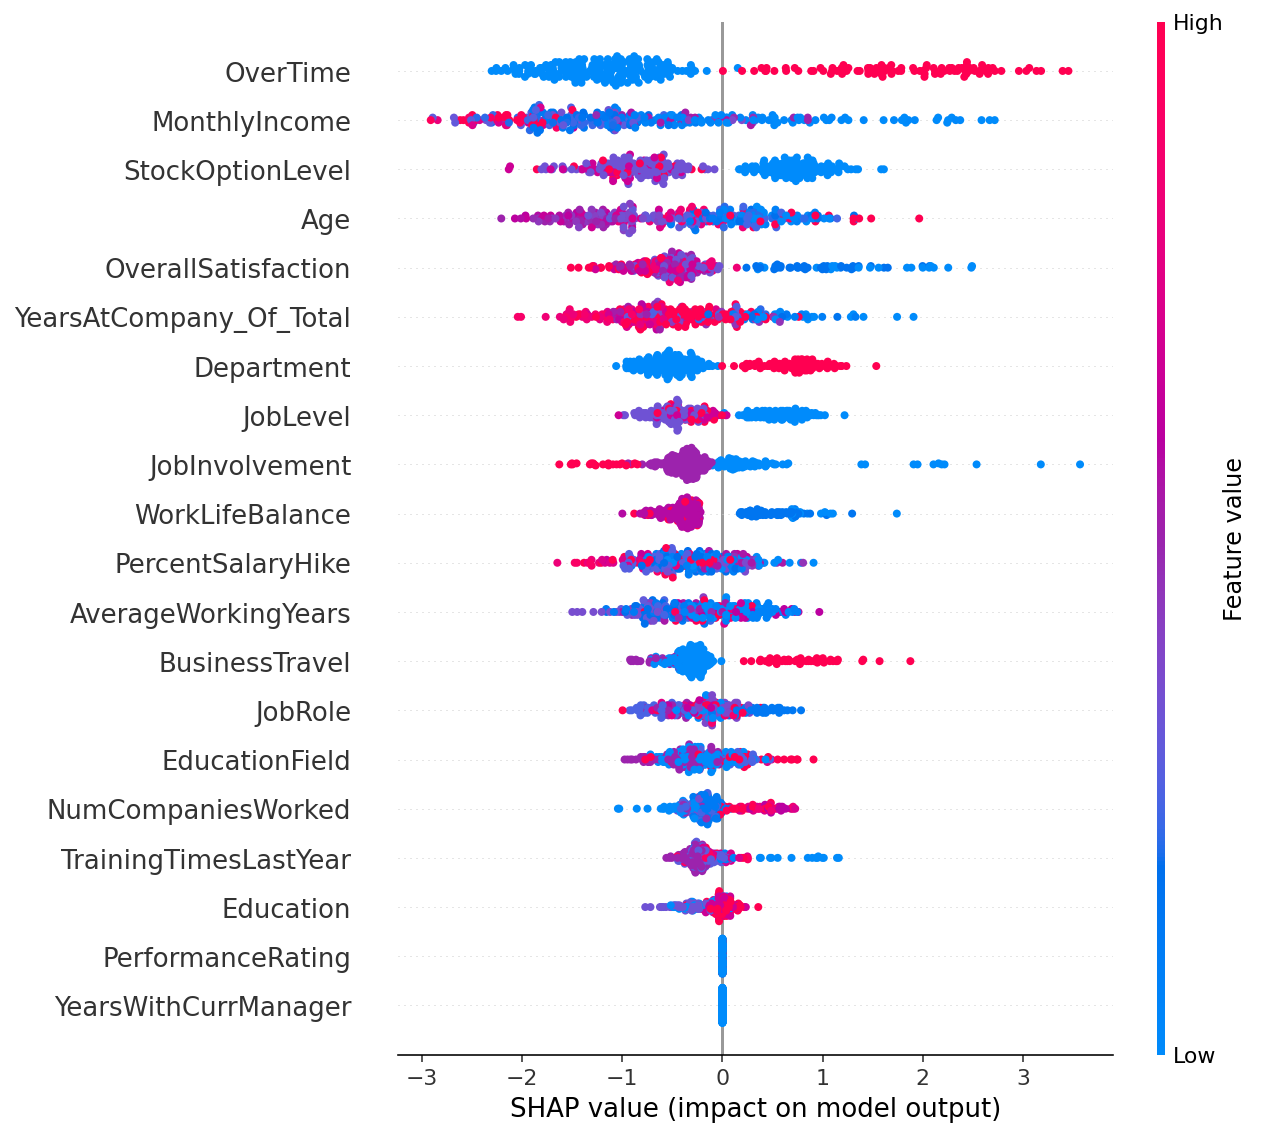

In [195]:
shap_values = explainer.shap_values(X_test_selected)
shap.summary_plot(shap_values, X_test_selected)

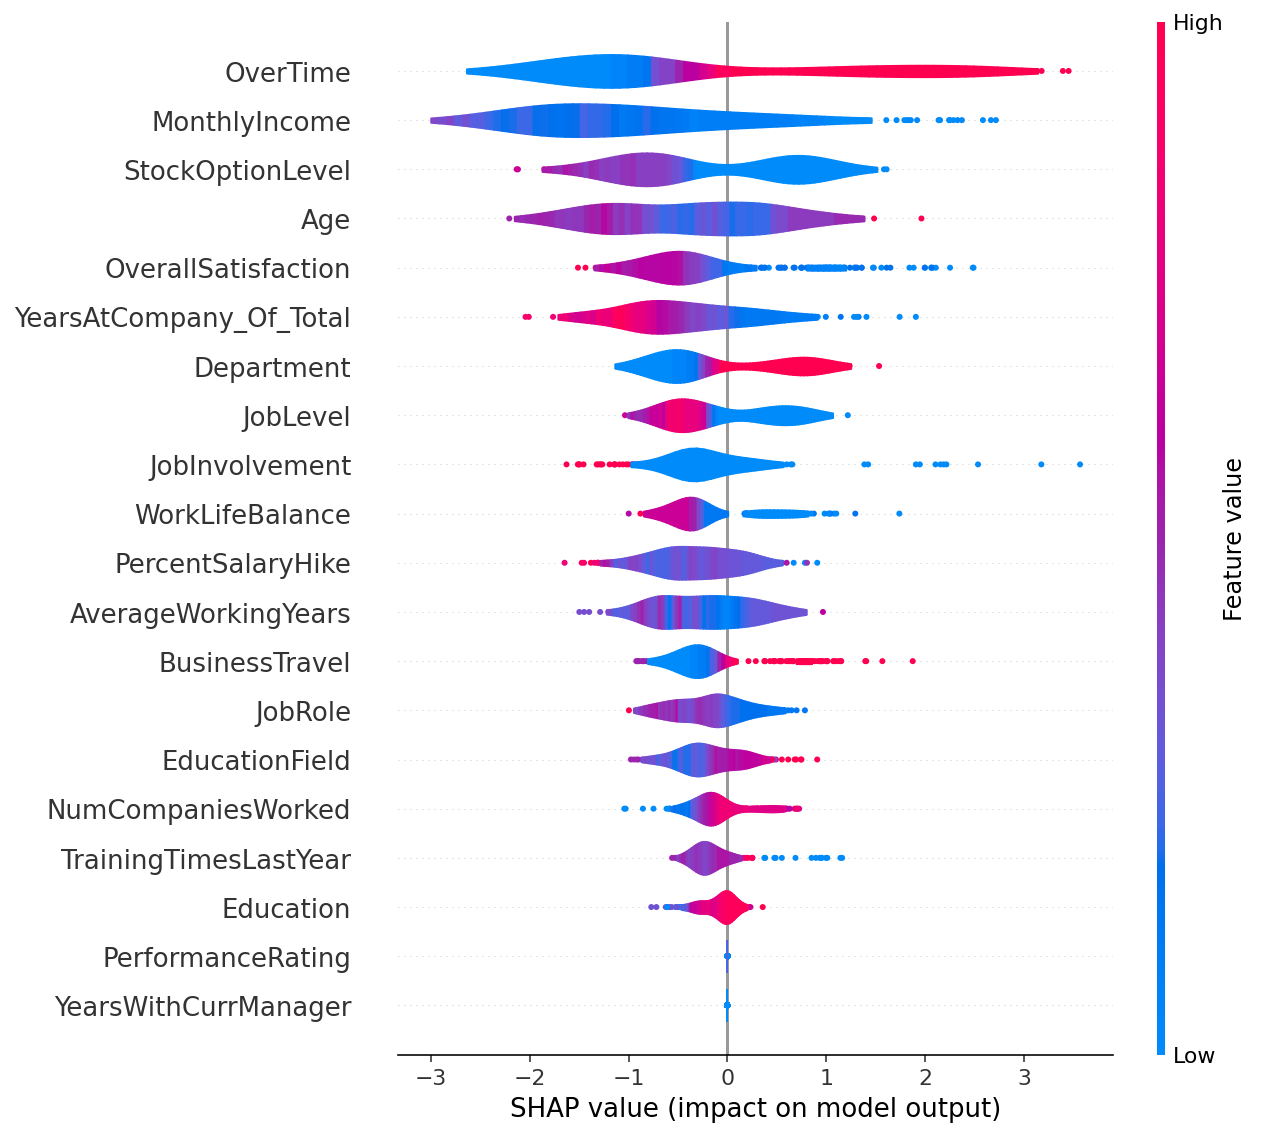

In [196]:
shap.summary_plot(shap_values, X_test_selected, plot_type="violin")

In [197]:
# 테스트셋의 갯수가 많지 않아 테스트셋 전체에 대한 shap value 요약 그래프를 그려보았다. (전체특성들이 shap value에 어떻게 영향을 주는지 확인 가능)
# 빨간색은 특성의 값 자체가 큰 경우, 파란색은 특성의 값 자체가 작은 경우임, 점은 아웃라이어.
# 상위 3개 특성 설명
# 가장 길게 그려지는 초과근무여부 특성은 분산이 상당히 크고 양, 음으로 모델에 영향을 주고 있다.
# 초과근무를 하는 사람일 수록 이직할 확률이 높아지는데에 영향을 주는 것으로 확인할 수 있다.
# 월 임금에 관한 특성은 양으로 보다는 음으로 모델에 영향을 주고 있다. 이직할 확률이 높을 것으로 모델이 예측하는 양의 방향에는 월 임금이 낮은 관측치들이 모여 있음을 확인할 수 있다.
# 스톡옵션 특성의 경우는 위의 특성들보다는 영향이 적지만, 스톡옵션의 여부에 따라 이직할 확률이 다르게 계산되고 있음을 보여준다. 
# 스톡옵션이 없거나 낮은경우는 이직할 확률에 positive한 영향을 주며, 스톡옵션이 높은 관측치들은 모델이 이직을 예측할 확률에 negative한 영향을 주고 있다.

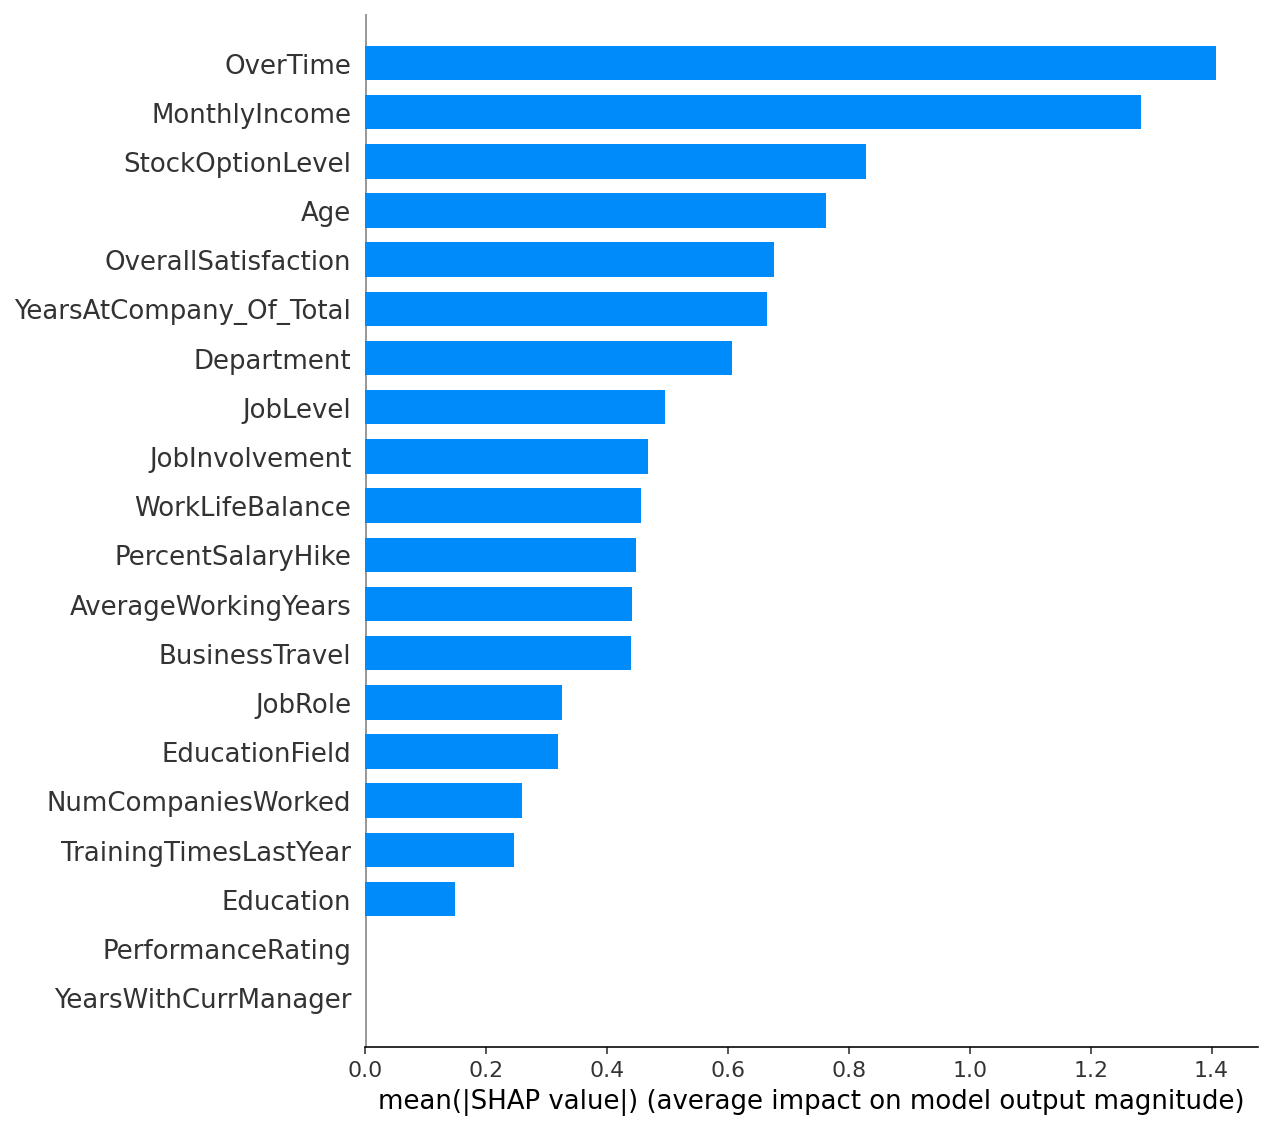

In [198]:
shap.summary_plot(shap_values, X_test_selected, plot_type="bar")